
**Cell Coverage Analysis for different protein expression**

This code processes images and calculates the coverage area of the cells in physical units (mm2) and also the coverage ratio. It allows the comparison of the coverage of cells with different expressing different proteins, in this case, for Actin, Pax, MAP2, Tau1, and p-Pax.

It handles cases where the low intensity of the image can make it harder to find the cell and generalize the processing of all images, so more aggressive techniques are used in these specific cases.

# Import Libraries

In [1]:
from google.colab.patches import cv2_imshow
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro
import scipy.stats as stats
import re
import seaborn as sns

# Image preprocessing

In [2]:
def contrast_stretching(image):
    """
    Enhance the contrast of an image by stretching its intensity range to the full 0-255 scale.

    Parameters:
        image (numpy.ndarray): The input image as a 2D or 3D numpy array.

    Returns:
        numpy.ndarray: The contrast-stretched image.
    """
    # Error checking for input type and values might be here

    min_val = np.min(image)
    max_val = np.max(image)

    # Avoid division by zero if the image has a constant value
    if min_val == max_val:
        return image

    stretched_image = (image - min_val) * (255 / (max_val - min_val))
    stretched_image = stretched_image.astype(np.uint8)

    return stretched_image


def apply_threshold(image, offset=5):
    """
    Apply Gaussian blurring followed by Otsu's thresholding to an image, with an optional offset to adjust the threshold.

    Parameters:
        image (numpy.ndarray): The input image.
        offset (int, optional): The value to adjust the Otsu's threshold. Default is 5.

    Returns:
        numpy.ndarray: The binary image after thresholding.
    """
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    _, preliminary_threshold = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    final_threshold = int(preliminary_threshold[0][0] + offset)
    _, binary_image = cv2.threshold(image, final_threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def apply_adaptive_threshold(image):
    """
    Apply adaptive thresholding using Gaussian C method to the input image.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        numpy.ndarray: The binary image after adaptive thresholding.
    """
    binary_image = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2)
    return binary_image

def apply_morphological_operations(binary_image):
    """
    Clean up a binary image by applying erosion followed by dilation.

    Parameters:
        binary_image (numpy.ndarray): The binary image to process.

    Returns:
        numpy.ndarray: The image after morphological processing.
    """
    kernel = np.ones((3, 3), np.uint8)
    binary_image = cv2.erode(binary_image, kernel, iterations=2)
    binary_image = cv2.dilate(binary_image, kernel, iterations=1)

    return binary_image

def additional_processing(image):
    """
    Apply a series of processing steps including gradient calculation, blurring, thresholding,
    and morphological operations to an image.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        numpy.ndarray: The processed image.
    """
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply thresholding to detect bright regions
    threshold = 5  # Adjust as needed
    binary_image = cv2.threshold(blurred_image, threshold, 255, cv2.THRESH_BINARY)[1]

    # Combine binary image and gradient magnitude
    peak_mask = cv2.bitwise_and(binary_image, (gradient_magnitude > threshold).astype(np.uint8) * 255)

    # Apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    peak_mask = cv2.morphologyEx(peak_mask, cv2.MORPH_CLOSE, kernel)

    return peak_mask


# Image Analysis Functions

In [7]:
def calculate_area(binary_image):
    """
    Calculate the total area covered by white pixels in the image, converting the area from square pixels to square millimeters.

    Parameters:
        binary_image (numpy.ndarray): A binary image where white pixels (value=255) represent the area of interest.

    Returns:
        float: The total area in square millimeters.
    """
    white_pixel_count = np.sum(binary_image == 255)

    # Convert pixel area to square millimeters using the global scale factor
    total_area_mm2 = white_pixel_count / (SCALE_FACTOR ** 2 * 10**6)
    return total_area_mm2


def calculate_coverage_ratio(binary_image):
    """
    Calculate the ratio of white pixels to the total number of pixels in the binary image, representing coverage ratio.

    Parameters:
        binary_image (numpy.ndarray): A binary image where white pixels (value=255) indicate coverage.

    Returns:
        float: The coverage ratio as a decimal.
    """
    white_pixel_count = np.sum(binary_image == 255)
    total_pixel_count = binary_image.size
    coverage_ratio = white_pixel_count / total_pixel_count
    return coverage_ratio


def calculate_intensity_stats(image, mask):
    """
    Calculate statistics (maximum, minimum, and mean intensity) for the non-zero values in a masked area of an image.

    Parameters:
        image (numpy.ndarray): The original image.
        mask (numpy.ndarray): A binary mask where the area of interest is marked with white pixels (value=255).

    Returns:
        tuple: A tuple containing the maximum, minimum, and mean intensity values. Returns None if there are no non-zero values.
    """
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    non_zero_values = masked_image[masked_image != 0]

    if non_zero_values.size == 0:
        return None  # Indicates no non-zero values found

    max_intensity = np.max(non_zero_values)
    min_intensity = np.min(non_zero_values)
    mean_intensity = np.mean(non_zero_values)
    return max_intensity, min_intensity, mean_intensity

def parse_folder_and_extract_protein_name(folder_name):
    """
    Extracts the diameter and pitch from the folder name, and also extracts the protein name.

    Parameters:
    - folder_name: The name of the folder, expected to contain information about diameter, pitch, and protein name.

    Returns:
    - A tuple containing the protein name, diameter, and pitch.
    """
    # Use regex to find the pattern for diameter and pitch
    match_diameter_pitch = re.search(r'D(\d+)P(\d+)', folder_name)
    if match_diameter_pitch:
        diameter = int(match_diameter_pitch.group(1))
        pitch = int(match_diameter_pitch.group(2))
    else:
        diameter = 0
        pitch = 0

    return diameter, pitch

def numerical_sort(condition):
    if condition == 'Flat':
      return (float('inf'), float('inf'))

    numbers = re.findall(r'\d+', condition)
    return tuple(int(x) for x in numbers)


# Main

In [8]:
def unified_plotting_function(all_plot_data):
    # Initialize variables
    plot_data_list = []
    normality_p_values = []

    # Assuming all_plot_data is the correct variable name for the list of dictionaries passed to this function
    for entry in all_plot_data:
        # Use .get() for safer access to dictionary keys
        area = entry.get('Area')
        ratio = entry.get('Ratio')
        protein_name = entry.get('Protein', 'Unknown')  # Provide default value 'Unknown' if 'Protein' key is missing
        condition = entry.get('Condition', 'Unknown')
        diameter = entry.get('Diameter', 0)
        pitch = entry.get('Pitch', 0)

        # Append to plot_data_list if needed, or directly use entry as it already contains the necessary data
        plot_data_list.append(entry)

    df_plot = pd.DataFrame(all_plot_data)
    # Assuming numerical_sort is defined elsewhere in your code
    df_plot['Condition'] = pd.Categorical(df_plot['Condition'], categories=sorted(df_plot['Condition'].unique(), key=numerical_sort), ordered=True)

    # Plotting Histograms and Q-Q Plots for each Condition
    conditions = df_plot['Condition'].unique()
    fig, axs = plt.subplots(len(conditions), 2, figsize=(10, len(conditions) * 4))
    for i, condition in enumerate(conditions):
        condition_data = df_plot[df_plot['Condition'] == condition]['Area']
        axs[i, 0].hist(condition_data, bins=20, alpha=0.7, color='blue', edgecolor='black')
        axs[i, 0].set_title(f'Histogram of Areas for {condition}')
        axs[i, 0].set_xlabel('Area (mm²)')
        axs[i, 0].set_ylabel('Frequency')
        stats.probplot(condition_data, dist="norm", plot=axs[i, 1])
        axs[i, 1].set_title(f'Q-Q Plot of Areas for {condition}')
    plt.tight_layout()
    plt.show()

    # Area Box Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Condition', y='Area', hue='Protein', data=df_plot).set_title('Coverage Area Distribution Across Conditions')
    plt.xticks(rotation=45)
    plt.show()

    # Ratio Box Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Condition', y='Ratio', hue='Protein', data=df_plot).set_title('Coverage Ratio Distribution Across Conditions')
    plt.xticks(rotation=45)
    plt.show()

    # Adjust 'ConditionLabel' to treat 'Flat' cases
    def condition_label(row):
        if 'Flat' in row['Condition']:
            return 'Flat'
        else:
            return f"D{row['Diameter']}P{row['Pitch']}"

    df_plot['ConditionLabel'] = df_plot.apply(condition_label, axis=1)

    # Sort conditions with 'Flat' being last and others by their numeric values
    condition_order = sorted(df_plot['ConditionLabel'].unique(), key=numerical_sort)
    df_plot['ConditionLabel'] = pd.Categorical(df_plot['ConditionLabel'], categories=condition_order, ordered=True)

    proteins = df_plot['Protein'].unique()  # Get all unique proteins

    for protein in proteins:
        # Filter the DataFrame for the current protein
        df_protein = df_plot[df_plot['Protein'] == protein]

        # Plot Area Box Plot for the current Protein by Condition
        plt.figure(figsize=(12, 6))  # Adjust size as needed
        sns.boxplot(x='ConditionLabel', y='Area', data=df_protein, order=condition_order)
        plt.title(f'Area Distribution for {protein} by Condition')
        plt.xticks(rotation=45)
        plt.xlabel('Condition (Diameter x Pitch)')
        plt.ylabel('Area')
        plt.show()

        # Optionally, if you want to plot Ratio as well
        plt.figure(figsize=(12, 6))  # Adjust size as needed
        sns.boxplot(x='ConditionLabel', y='Ratio', data=df_protein, order=condition_order)
        plt.title(f'Ratio Distribution for {protein} by Condition')
        plt.xticks(rotation=45)
        plt.xlabel('Condition (Diameter x Pitch)')
        plt.ylabel('Ratio')
        plt.show()

    # ANOVA Analysis for 'Area'
    model = ols('Area ~ C(Condition) + C(Protein) + C(Condition):C(Protein)', data=df_plot).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA table for 'Area':")
    print(anova_table)

    # Heatmaps for Area and Ratio
    plt.figure(figsize=(12, 6))
    heatmap_data_area = df_plot.pivot_table(index='Condition', columns='Protein', values='Area', aggfunc='mean').fillna(0)
    sns.heatmap(heatmap_data_area, cmap='viridis', annot=False, fmt=".2f", cbar_kws={'label': 'Area (mm2)'}).set_title('Coverage Area Across Different Substrate Conditions')
    plt.show()

    plt.figure(figsize=(12, 6))
    heatmap_data_ratio = df_plot.pivot_table(index='Condition', columns='Protein', values='Ratio', aggfunc='mean').fillna(0)
    sns.heatmap(heatmap_data_ratio, cmap='viridis', annot=False, fmt=".2f", cbar_kws={'label': 'Coverage Ratio'}).set_title('Coverage Ratio Across Different Substrate Conditions')
    plt.show()


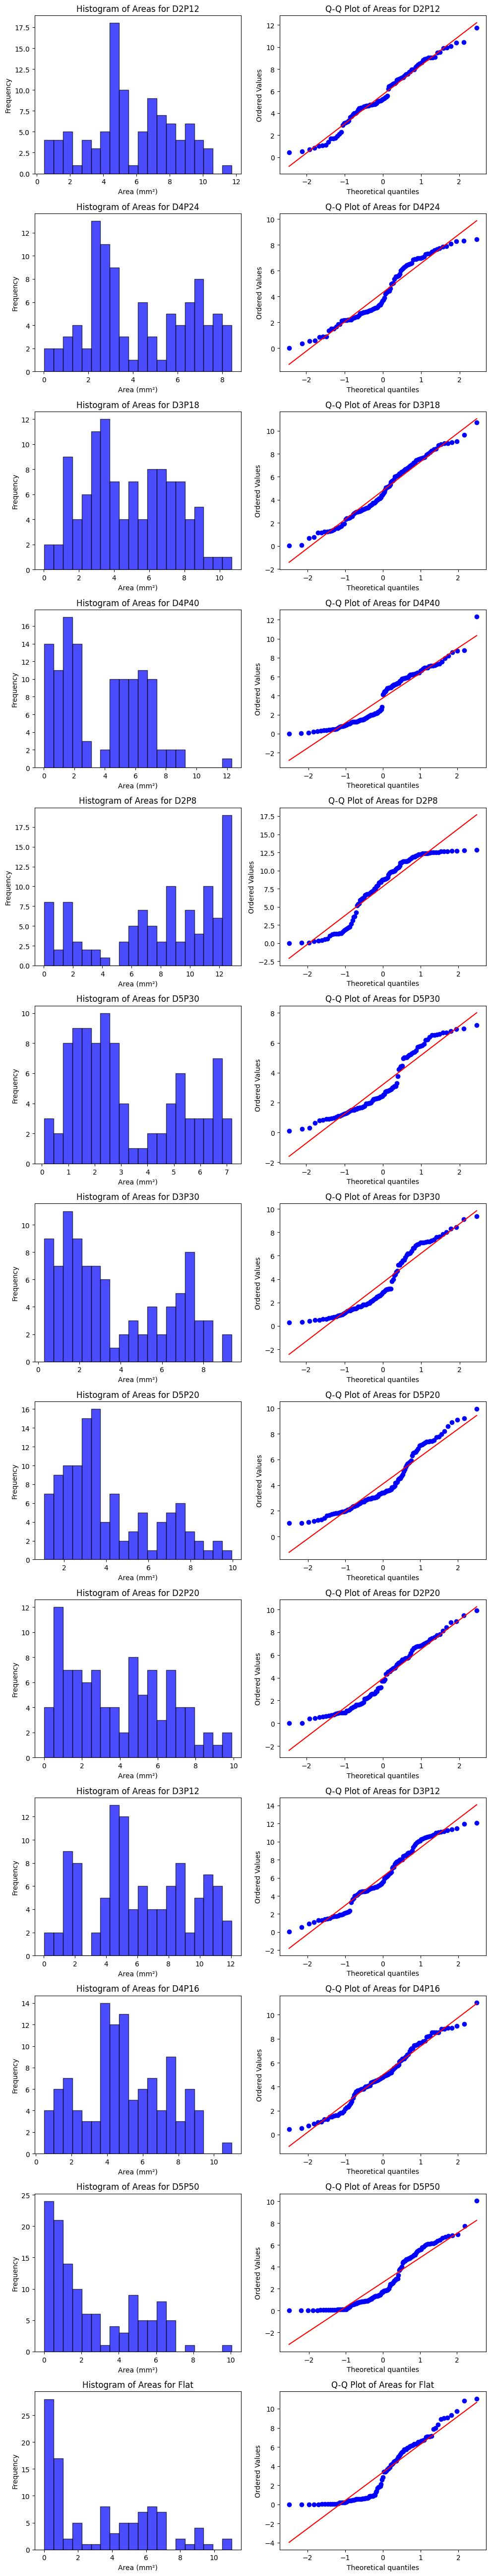

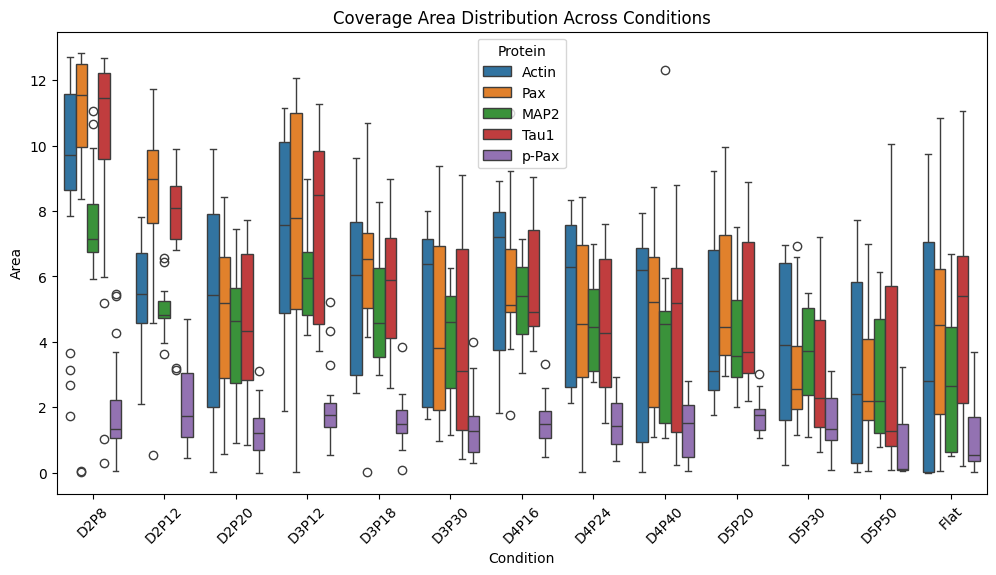

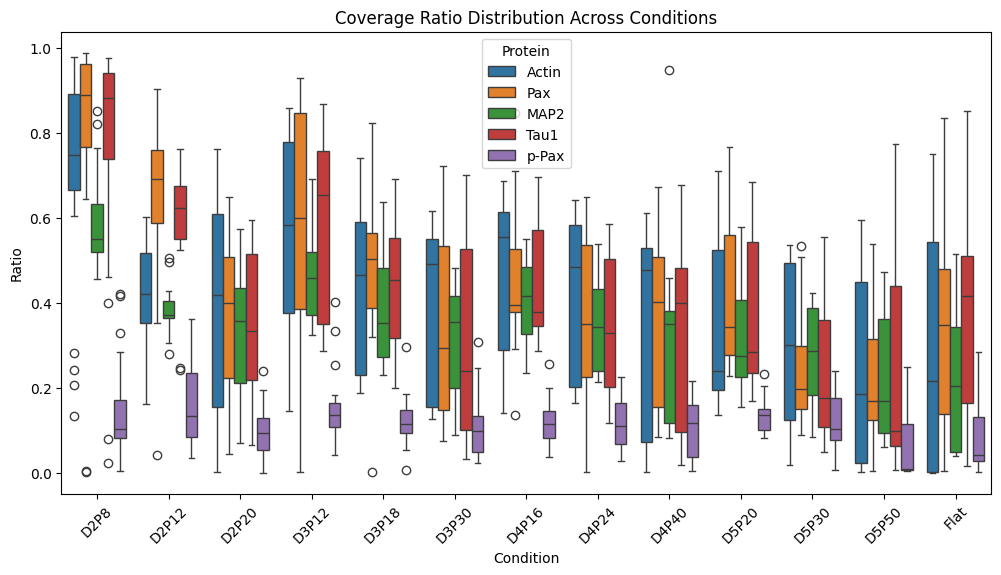

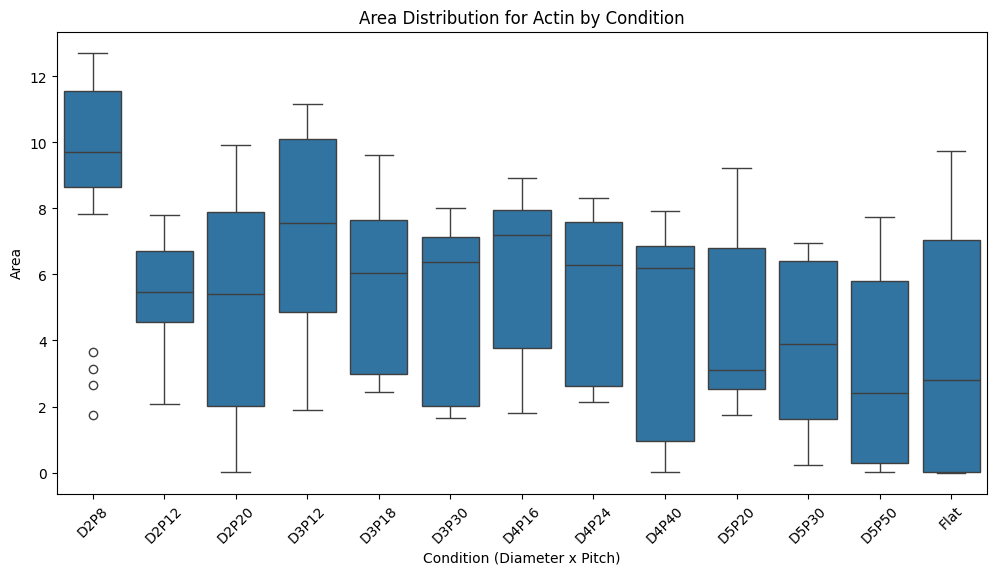

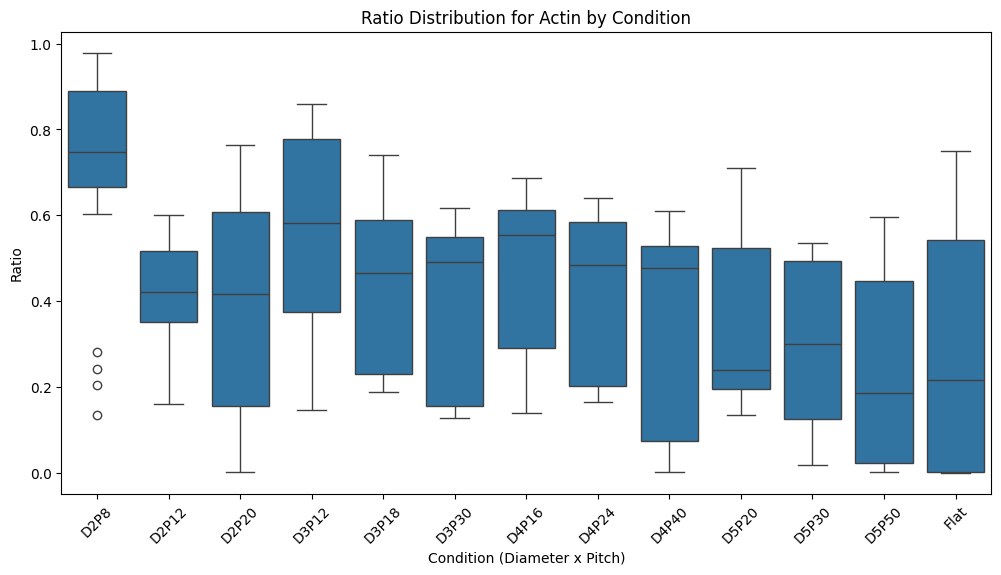

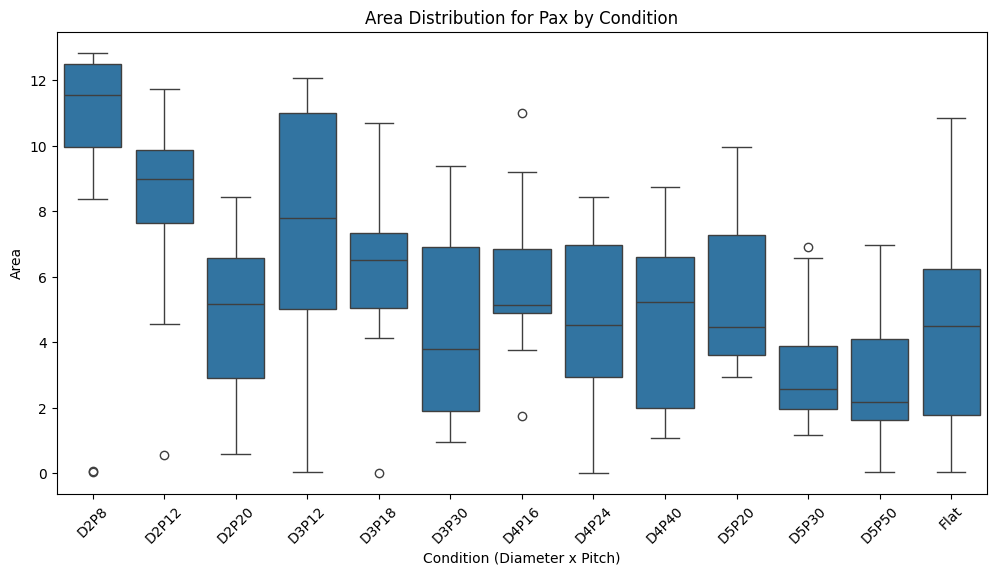

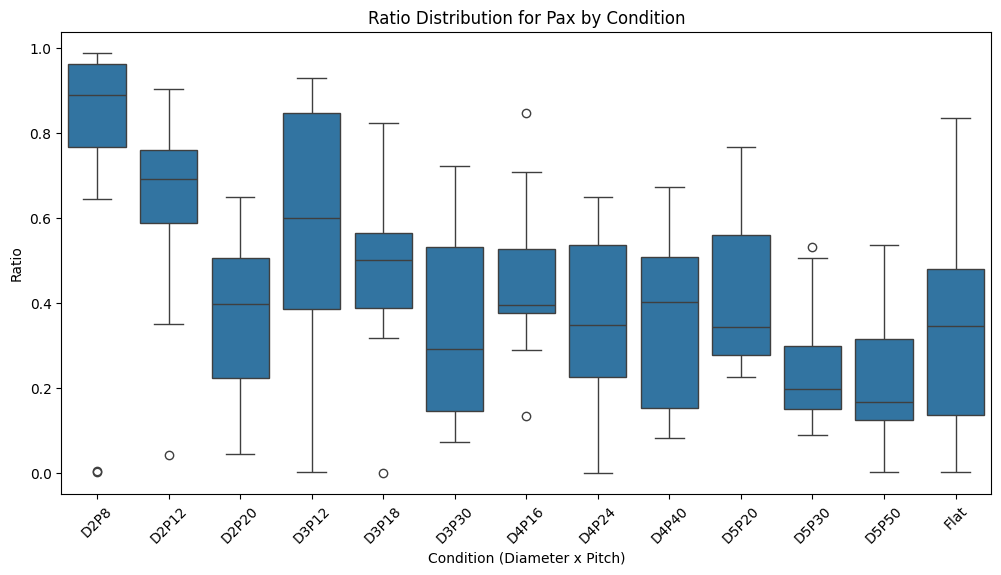

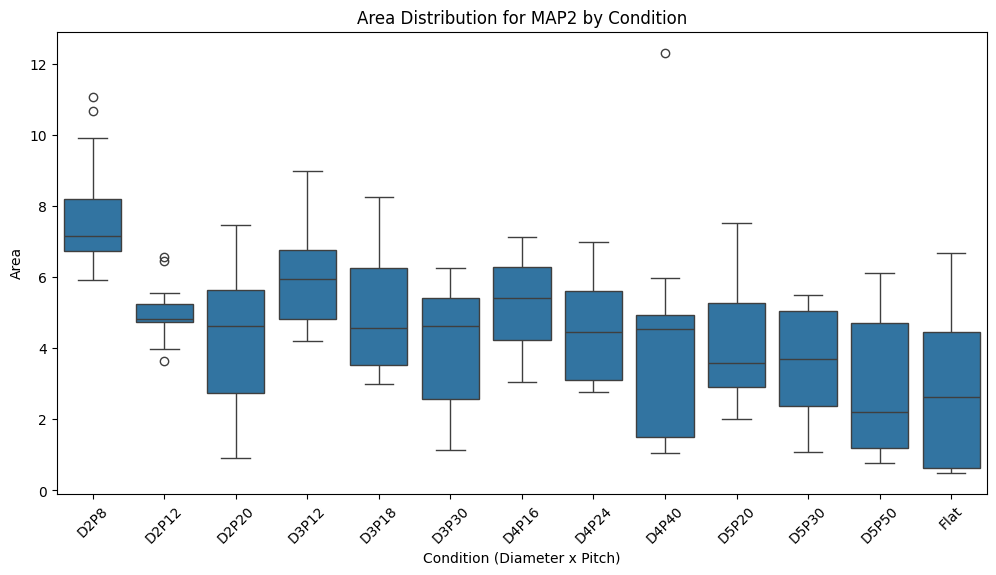

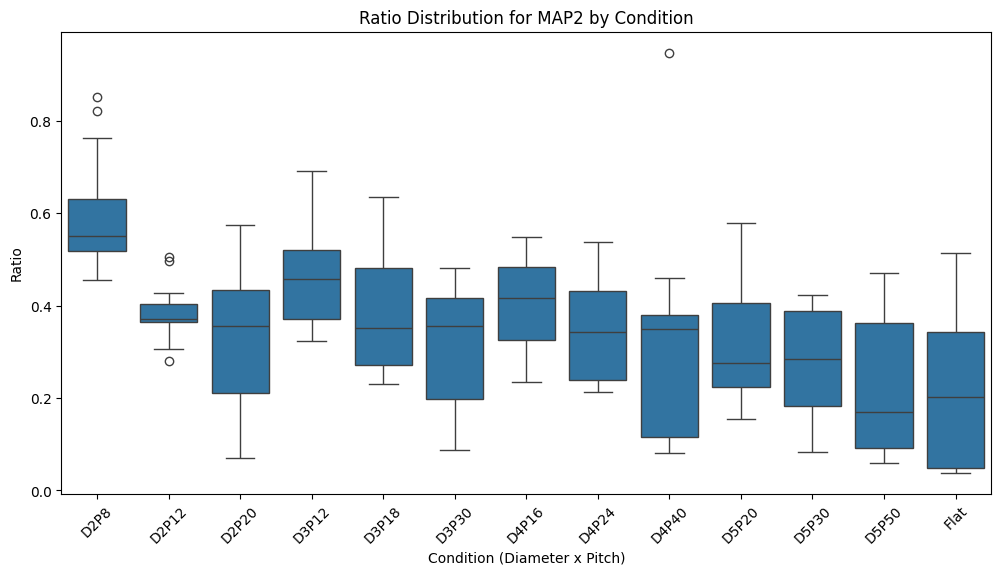

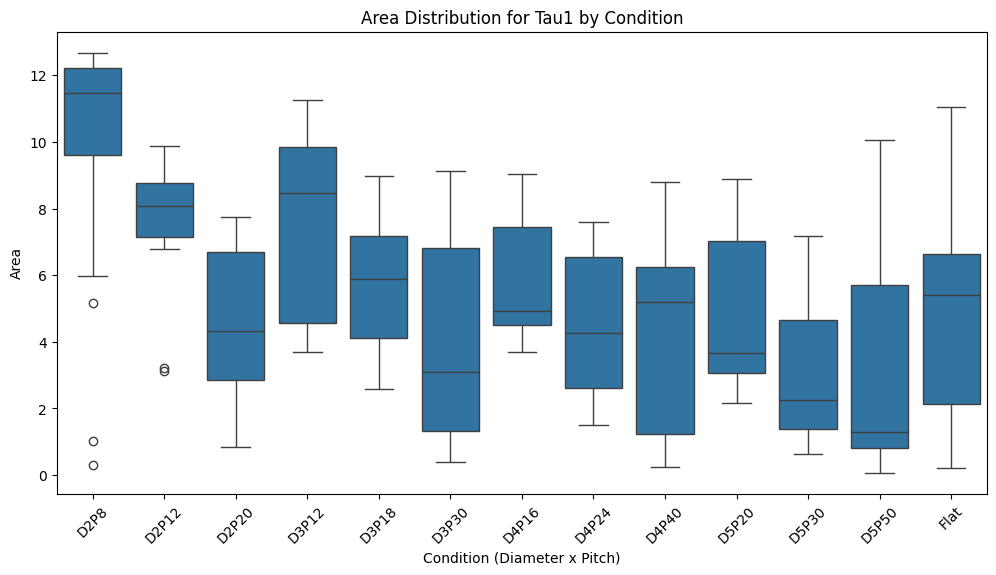

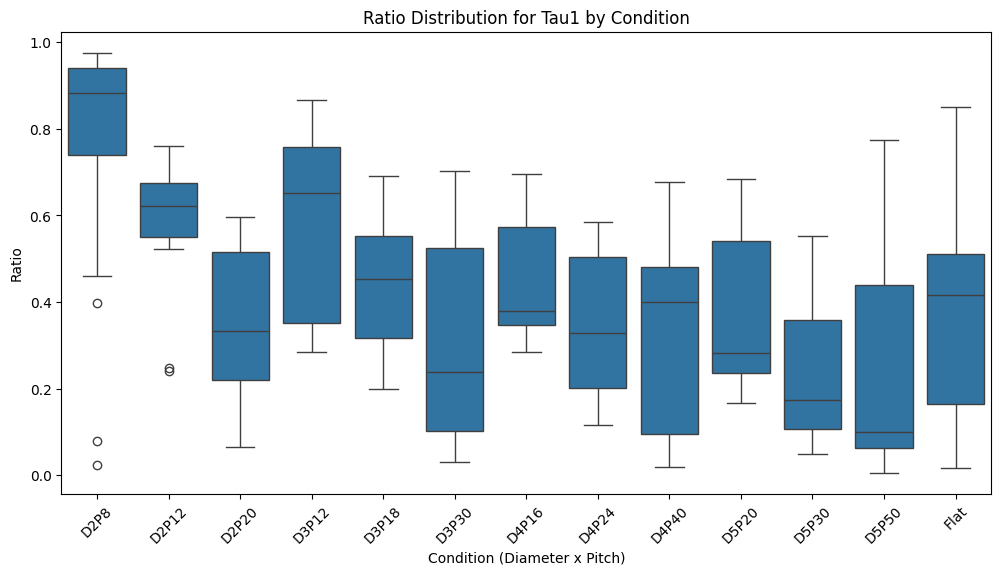

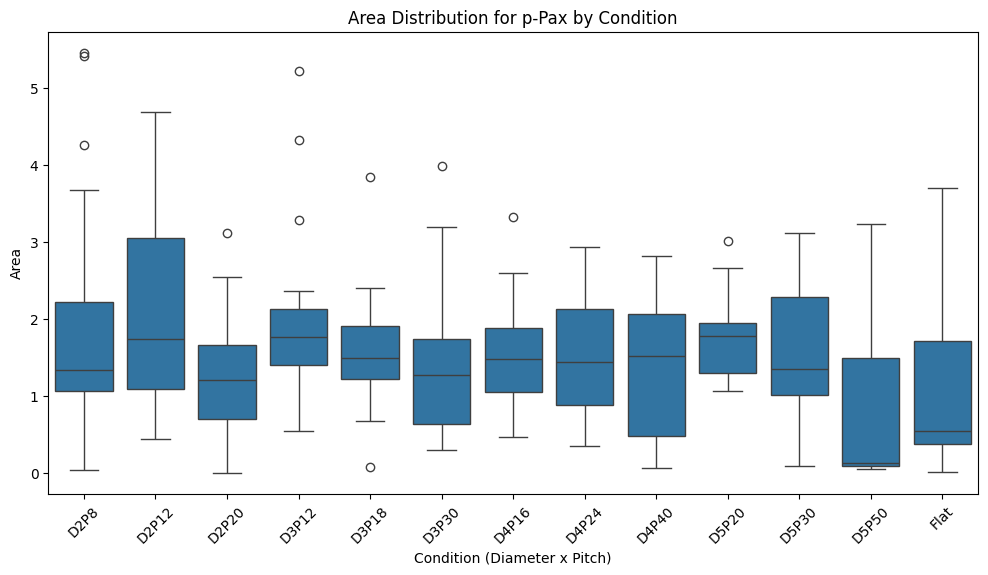

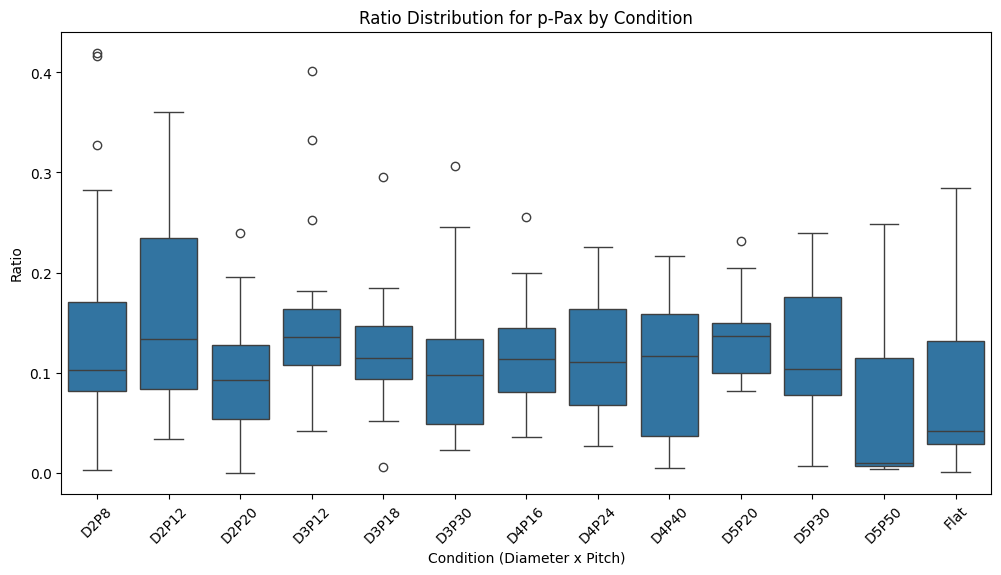

ANOVA table for 'Area':
                              sum_sq      df           F        PR(>F)
C(Condition)             2614.553211    12.0   43.111601  3.303802e-86
C(Protein)               2808.514025     4.0  138.929515  4.030985e-99
C(Condition):C(Protein)   631.508823    48.0    2.603251  2.714024e-08
Residual                 6660.970272  1318.0         NaN           NaN


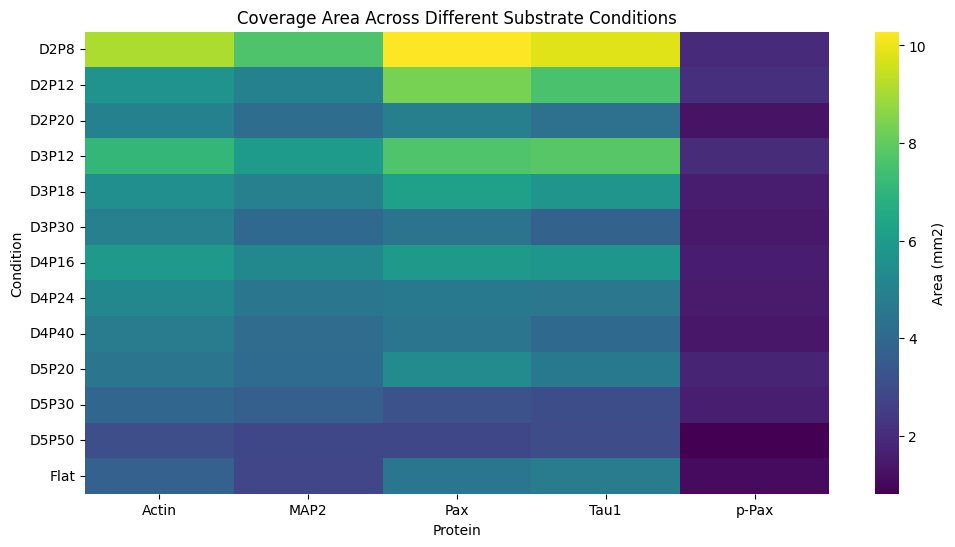

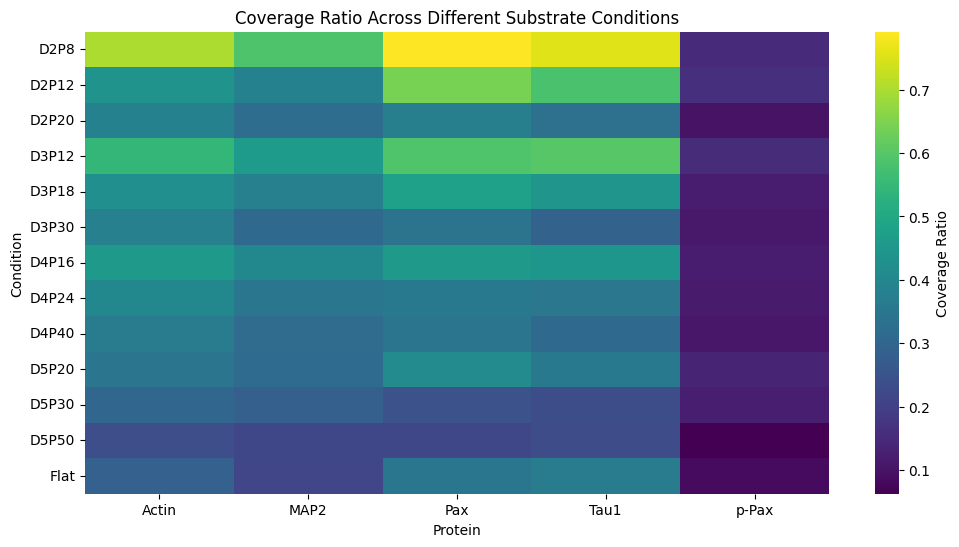

In [9]:
# Constants
SCALE_FACTOR = 1 / 3  # 3 pixels per micrometer

def process_images_in_folder(folder_path, folder_title, scale_factor):
    folder_data = []

    # Get the list of image files in the subfolder
    image_files = [filename for filename in os.listdir(folder_path) if filename.endswith(".tif")]

    # Iterate over the files in the subfolder
    for i, filename in enumerate(image_files):
        if filename.endswith(".tif"):
            # Load the image
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            stretched_image = contrast_stretching(image)

            # Apply thresholding and display the binary image
            binary_image = apply_threshold(stretched_image, offset=4)

            # Apply morphological operations and display the result
            binary_image = apply_morphological_operations(binary_image)

            # Calculate the total area using the binary image
            total_area_mm2 = calculate_area(binary_image)
            total_area_ratio = calculate_coverage_ratio(binary_image)
            protein_name = (os.path.basename(os.path.dirname(folder_path)))
            diameter, pitch =  parse_folder_and_extract_protein_name(folder_path)
            condition = 'Flat' if (diameter, pitch) == (0,0) else f"D{diameter}P{pitch}"
            # Initialize the data entry dictionary
            data_entry = {
                'filename': filename,
                'Protein': protein_name,
                'Pitch':pitch,
                'Diameter':diameter,
                'Condition':condition,
                'Area': total_area_mm2,
                'Ratio': total_area_ratio,
                'max_intensity': 0,
                'min_intensity': 0,
                'mean_intensity': 0,
                'used_peak_mask': False
            }

            # If the area is zero after global thresholding, try adaptive thresholding
            if total_area_mm2 == 0:
                peak_mask = additional_processing(stretched_image)
                binary_image = apply_morphological_operations(peak_mask)
                total_area_mm2 = calculate_area(binary_image)
                total_area_ratio = calculate_coverage_ratio(binary_image)
                data_entry['Area'] = total_area_mm2
                data_entry['Ratio'] = total_area_ratio
                data_entry['used_peak_mask'] = True

            # If the area is non-zero but very small, consider additional processing with peak mask
            elif total_area_mm2 < 0.2:
                peak_mask = additional_processing(stretched_image)
                binary_image = apply_morphological_operations(peak_mask)
                total_area_mm2 = calculate_area(binary_image)
                total_area_ratio = calculate_coverage_ratio(binary_image)
                data_entry['Area'] = total_area_mm2
                data_entry['Ratio'] = total_area_ratio
                data_entry['used_peak_mask'] = True

            # Update intensity statistics if area is non-zero
            if total_area_mm2 > 0:
                max_intensity, min_intensity, mean_intensity = calculate_intensity_stats(image, binary_image)
                data_entry.update({
                    'max_intensity': max_intensity,
                    'min_intensity': min_intensity,
                    'mean_intensity': mean_intensity,
                })

            # Append the data entry to folder_data
            folder_data.append(data_entry)

    return folder_data

def process_parent_folder(parent_folder):
    subfolders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]
    all_data = {}
    for subfolder in subfolders:
        folder_path = os.path.join(parent_folder, subfolder)
        folder_title = f"Pattern: {subfolder}"  # Adjust this if needed
        folder_data = process_images_in_folder(folder_path, folder_title, SCALE_FACTOR)  # Assuming this function is defined elsewhere
        all_data[subfolder] = folder_data
    return all_data

def main():
    parent_folders = [
        '/content/drive/MyDrive/MAIA/3.Semester/Germany Master Thesis/Neuroimaging project/Cell_coverage/Actin',
        '/content/drive/MyDrive/MAIA/3.Semester/Germany Master Thesis/Neuroimaging project/Cell_coverage/Pax',
        '/content/drive/MyDrive/MAIA/3.Semester/Germany Master Thesis/Neuroimaging project/Cell_coverage/MAP2',
        '/content/drive/MyDrive/MAIA/3.Semester/Germany Master Thesis/Neuroimaging project/Cell_coverage/Tau1',
        '/content/drive/MyDrive/MAIA/3.Semester/Germany Master Thesis/Neuroimaging project/Cell_coverage/p-Pax',
    ]
    all_plot_data = []
    for parent_folder in parent_folders:
        protein_data = process_parent_folder(parent_folder)
        for subfolder, data_entries in protein_data.items():
            for data_entry in data_entries:
                all_plot_data.append(data_entry)
    unified_plotting_function(all_plot_data)

if __name__ == "__main__":
    main()


## Image Processing Results (One Protein)

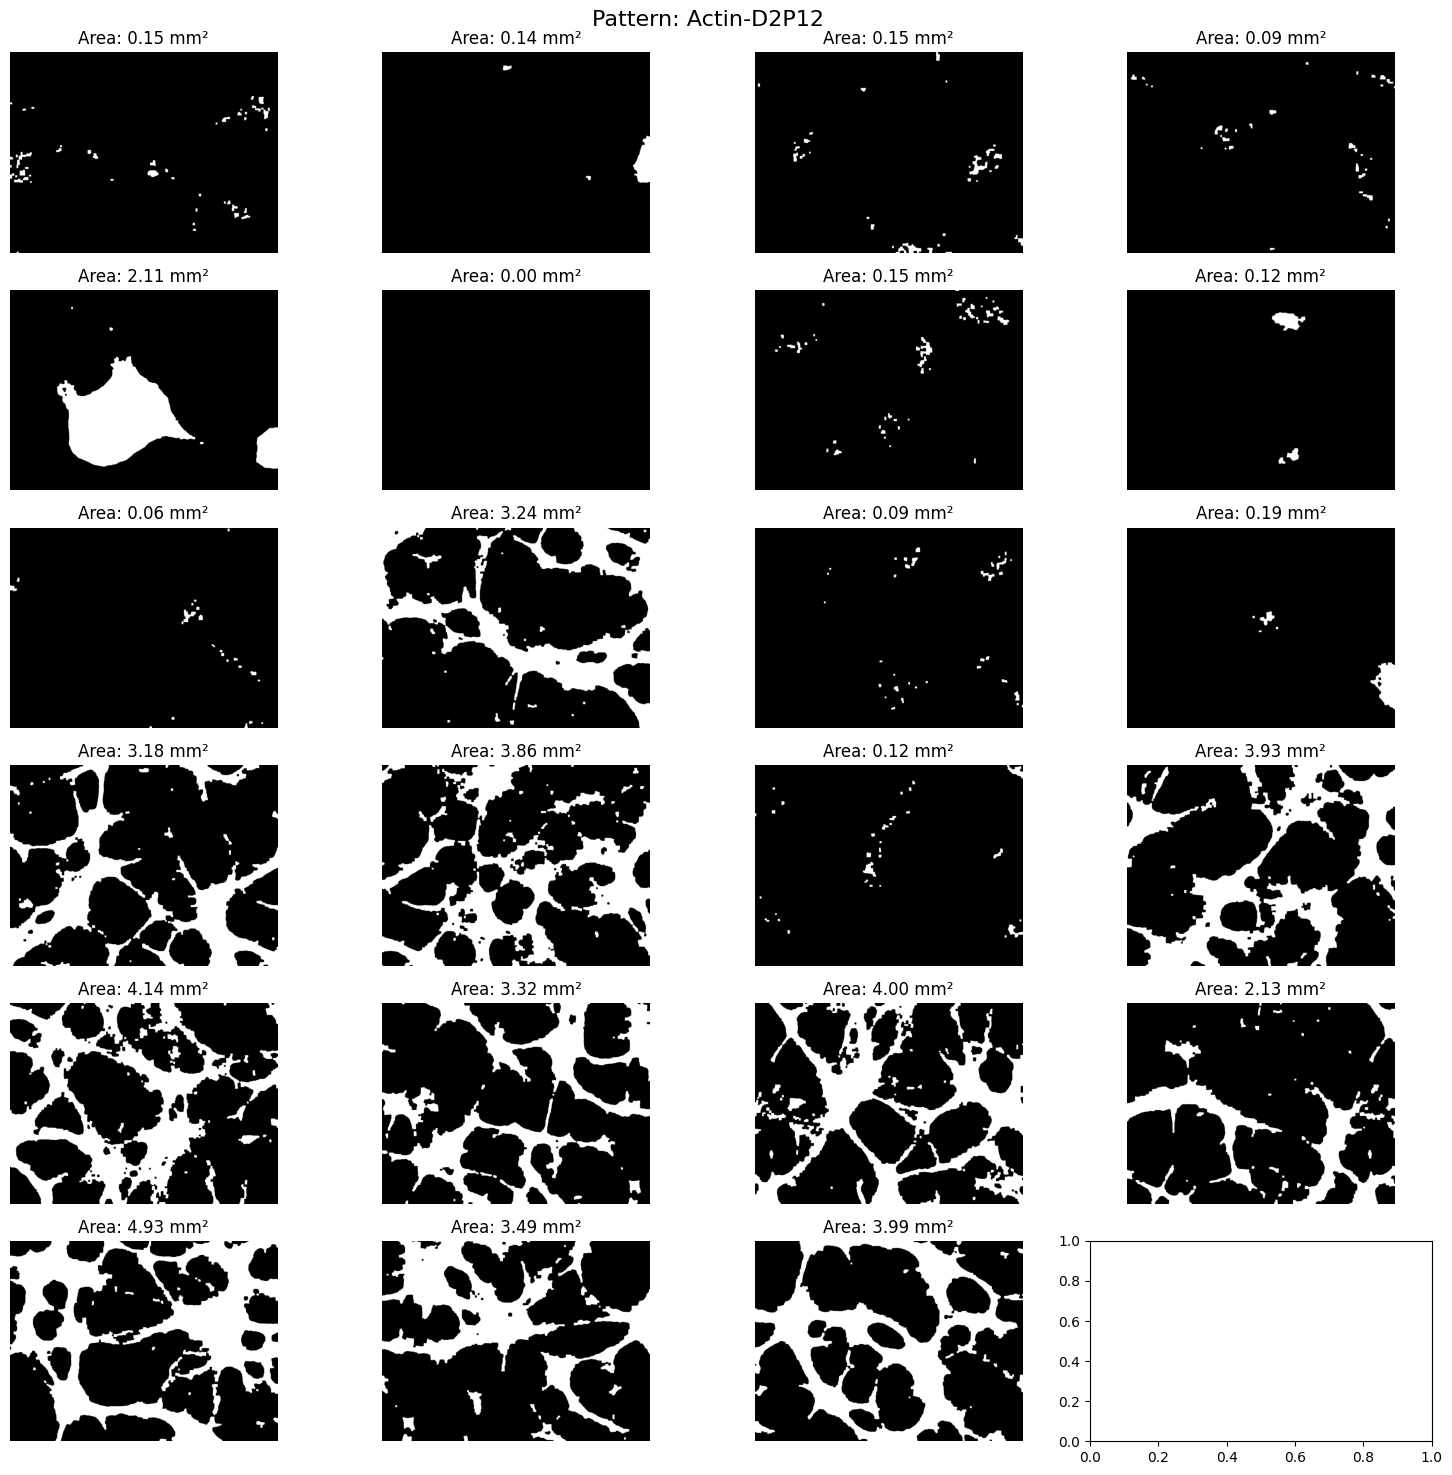

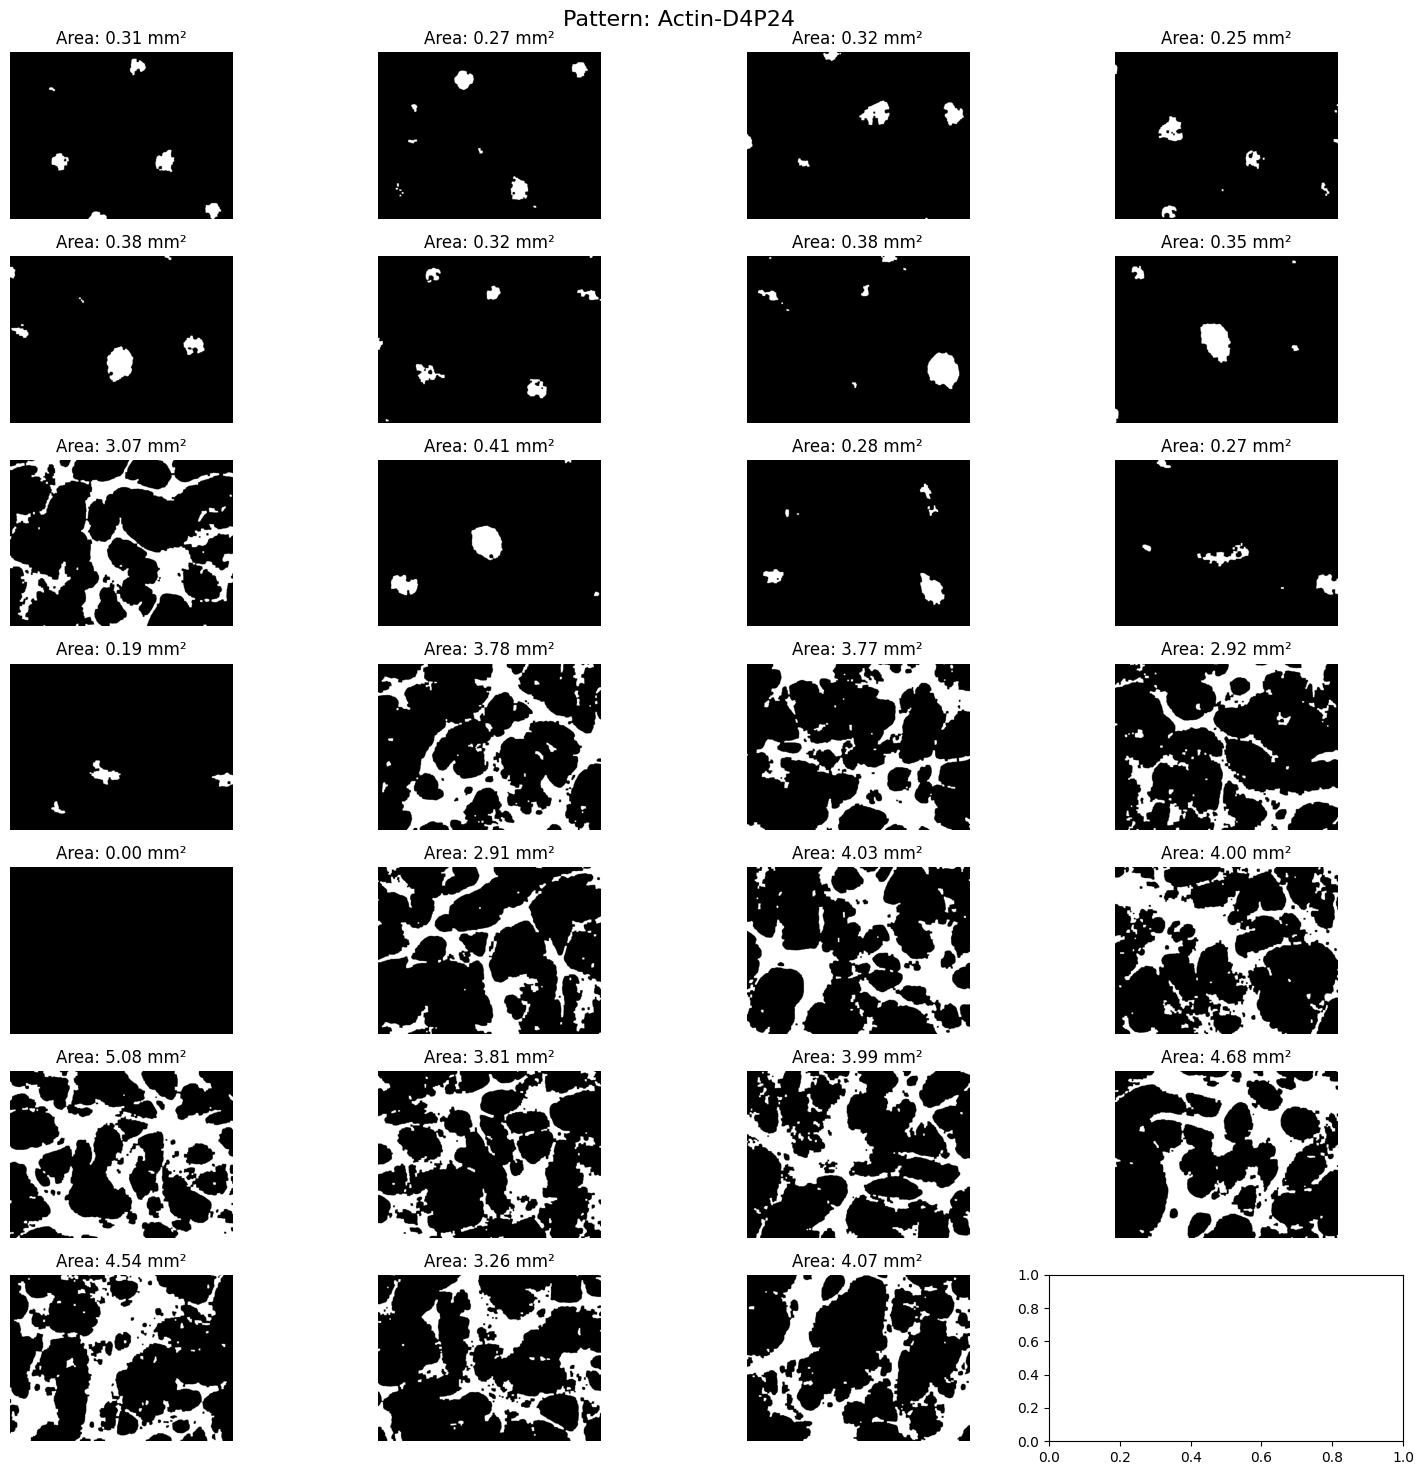

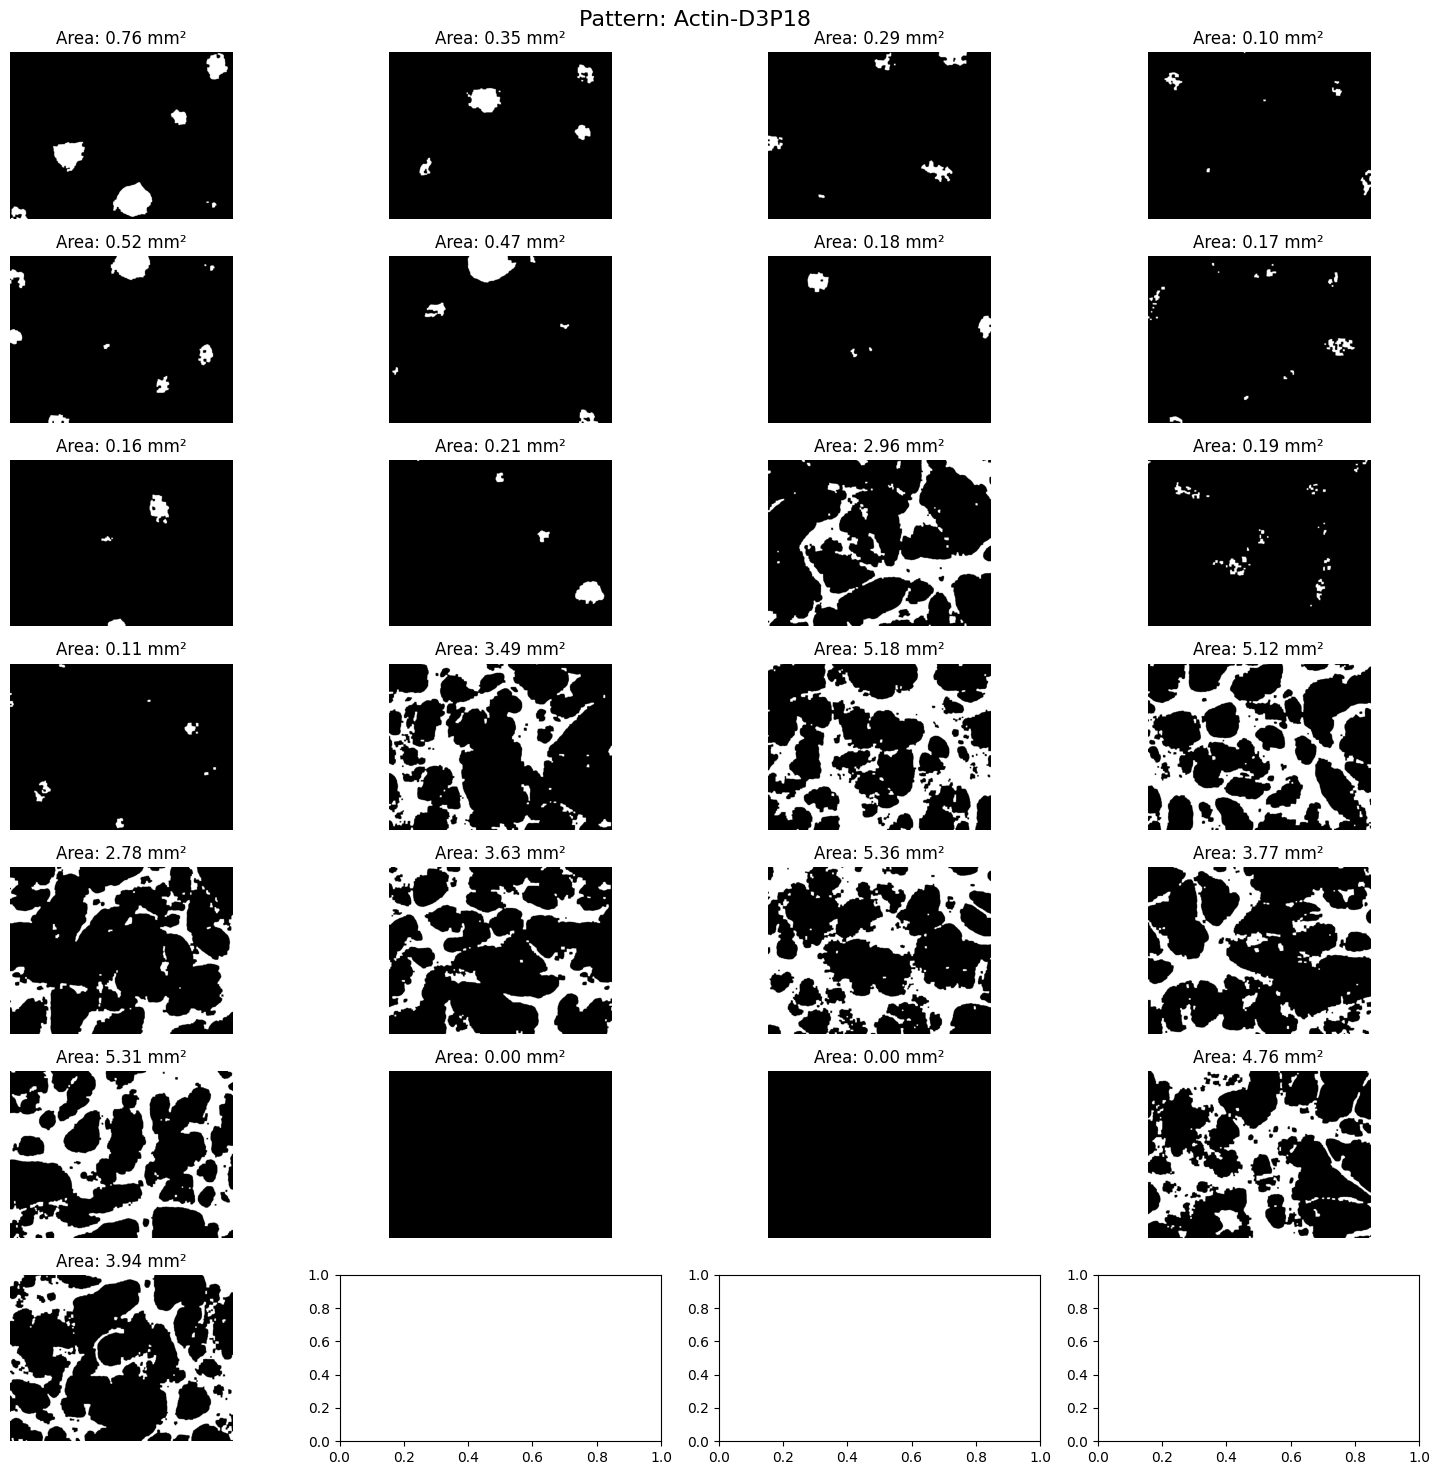

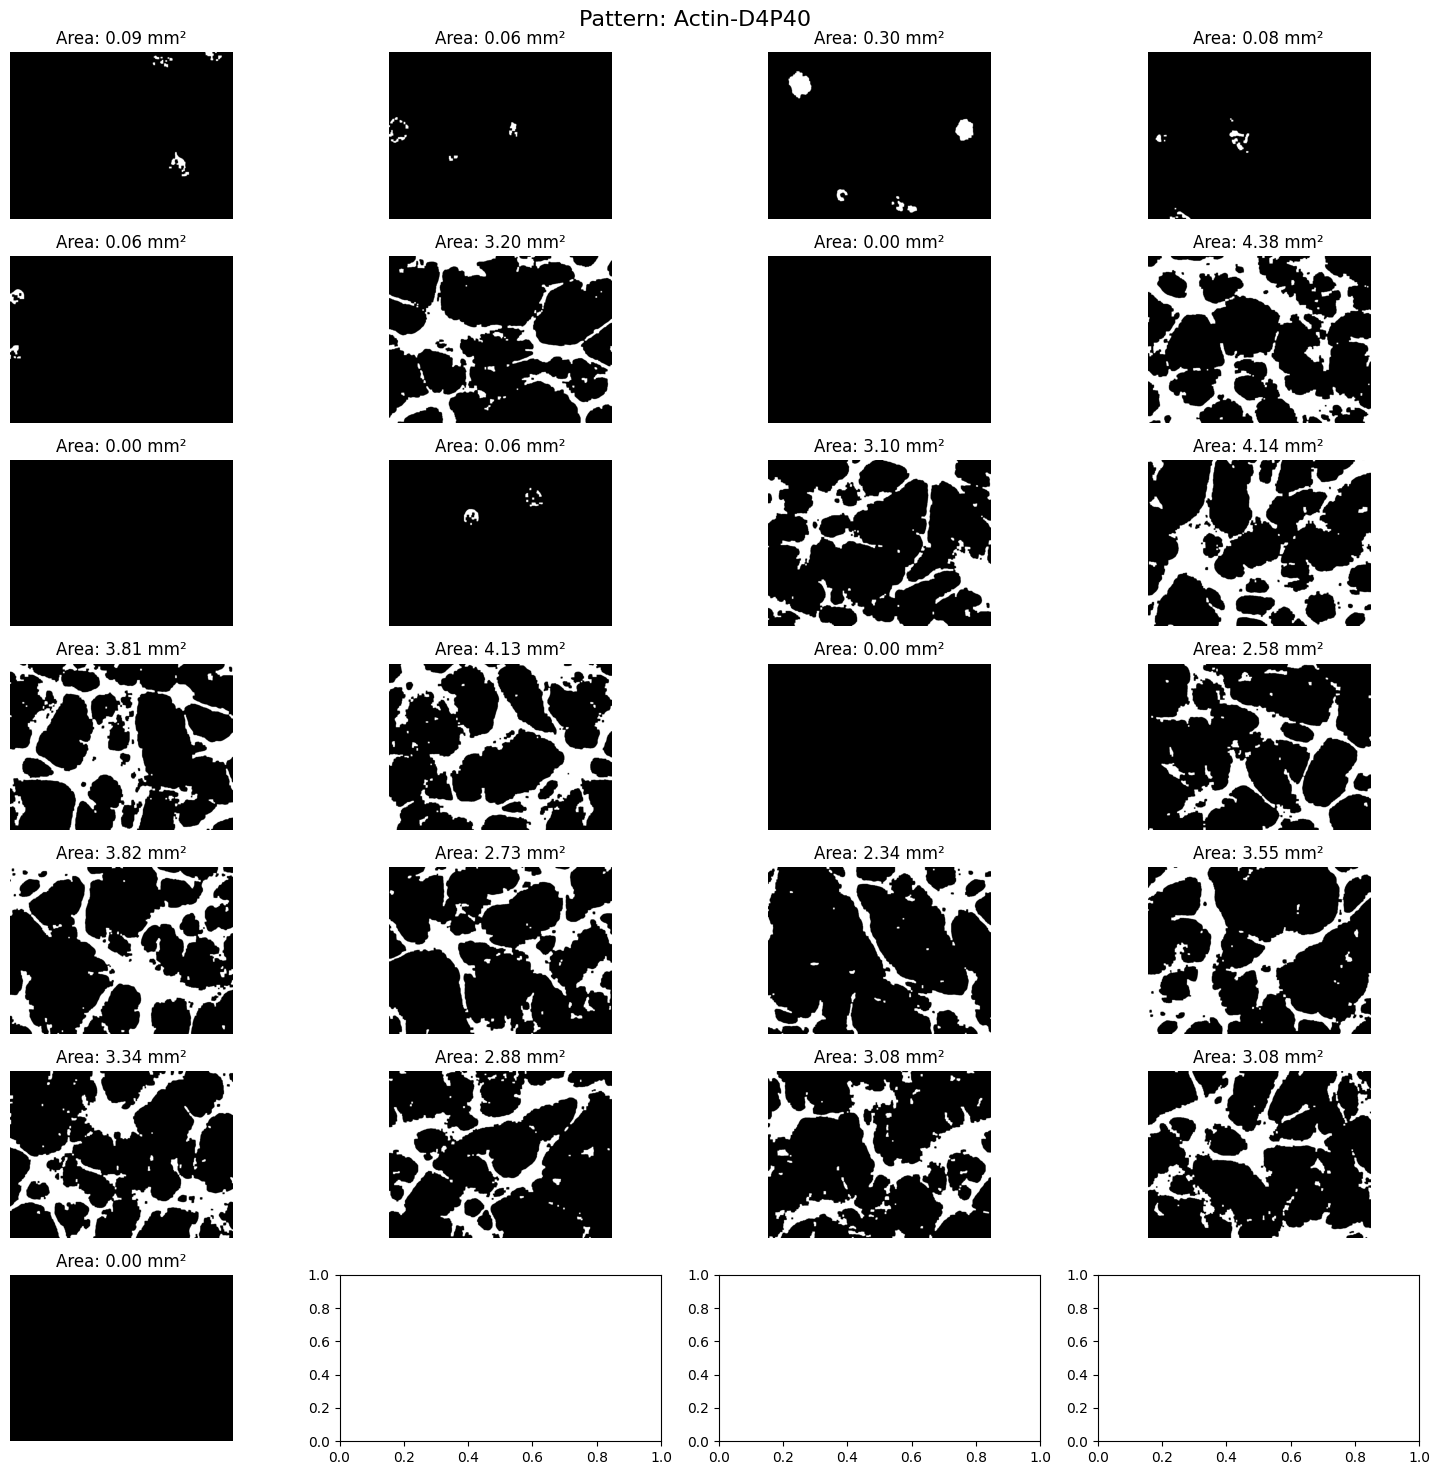

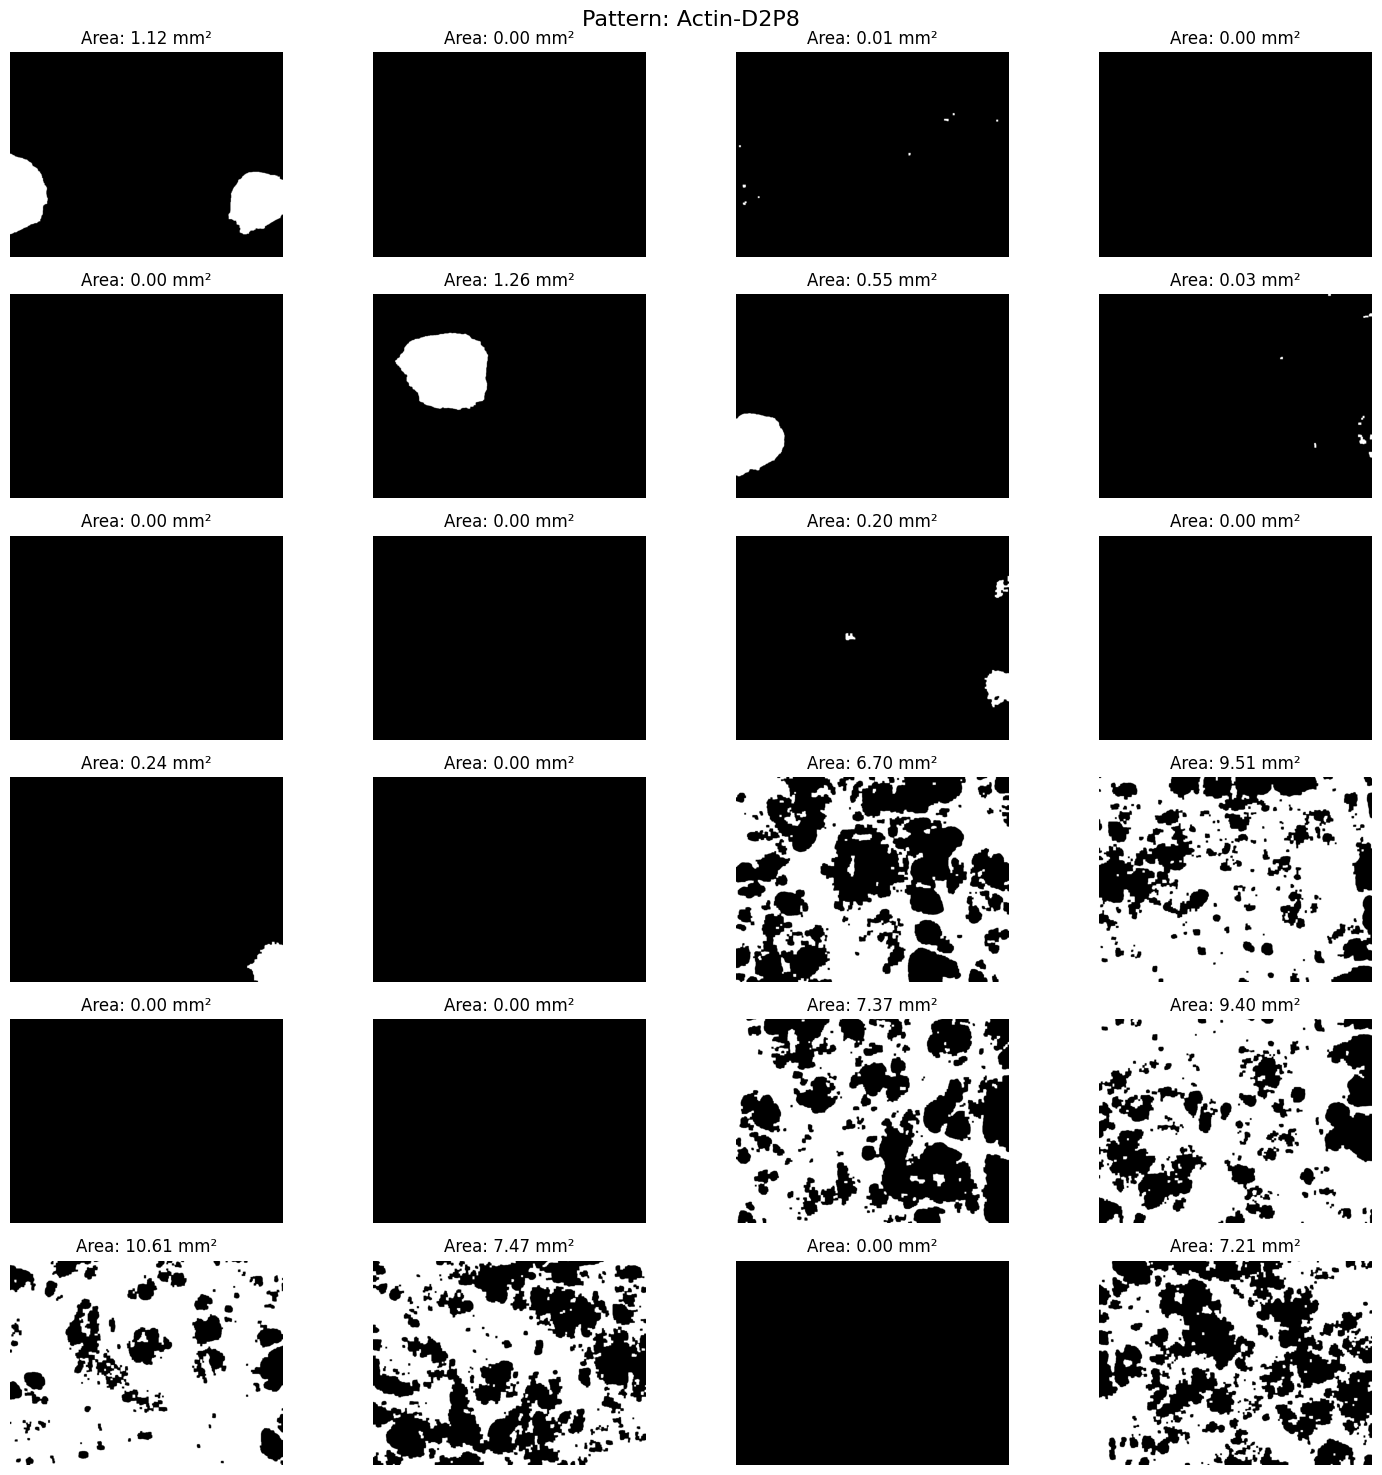

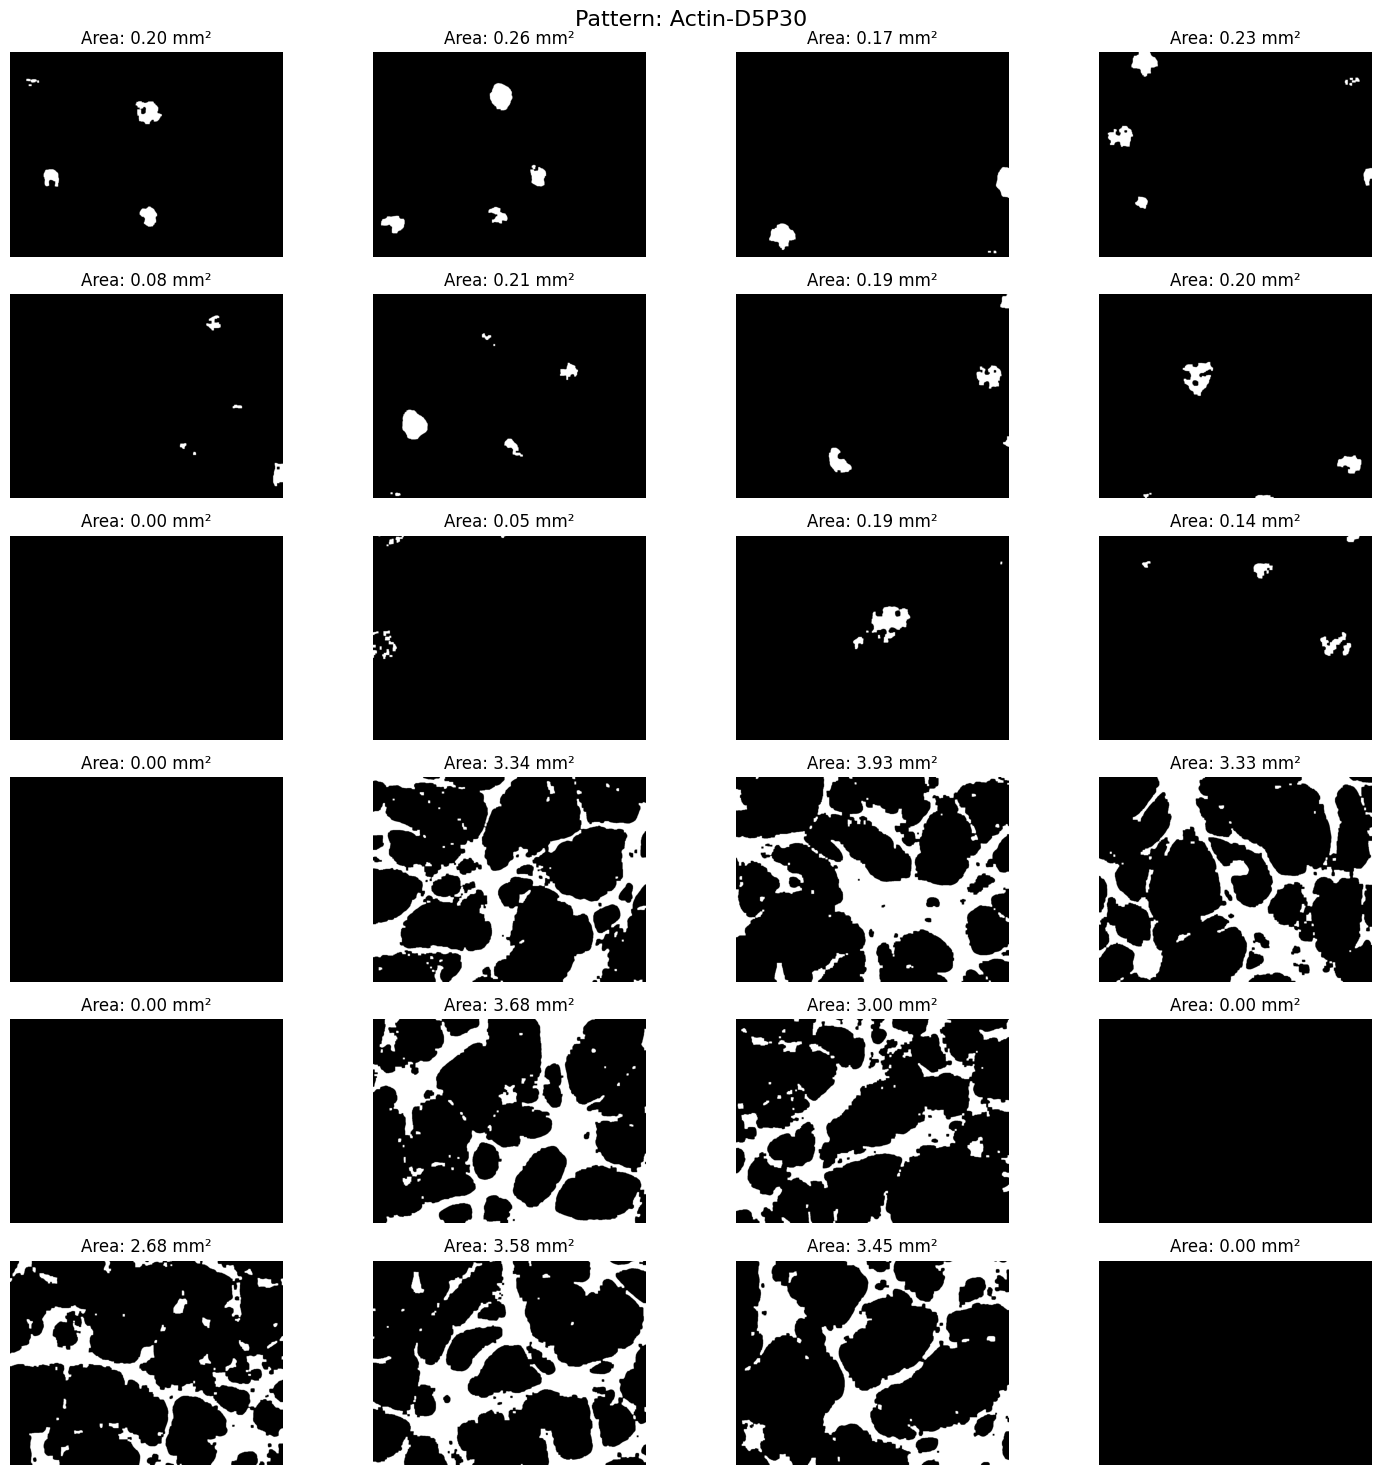

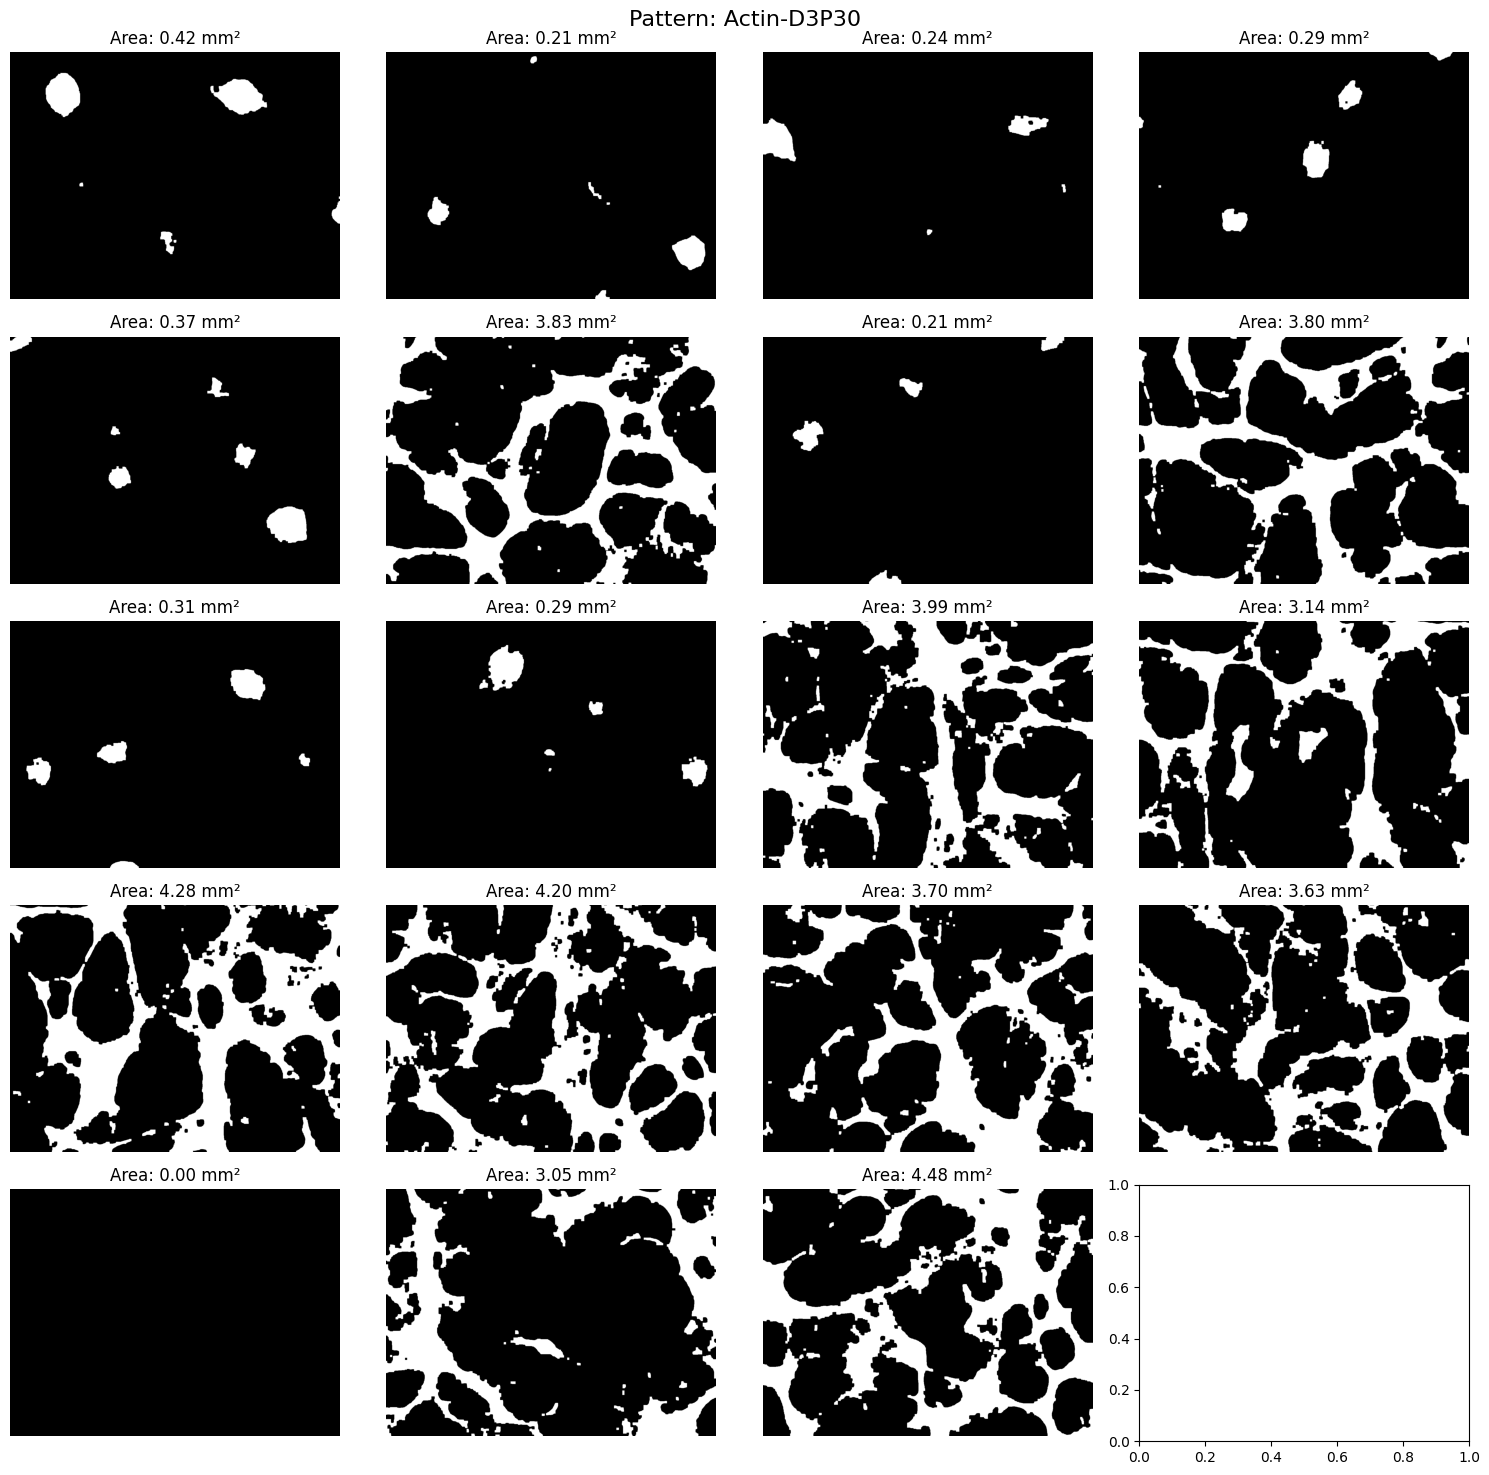

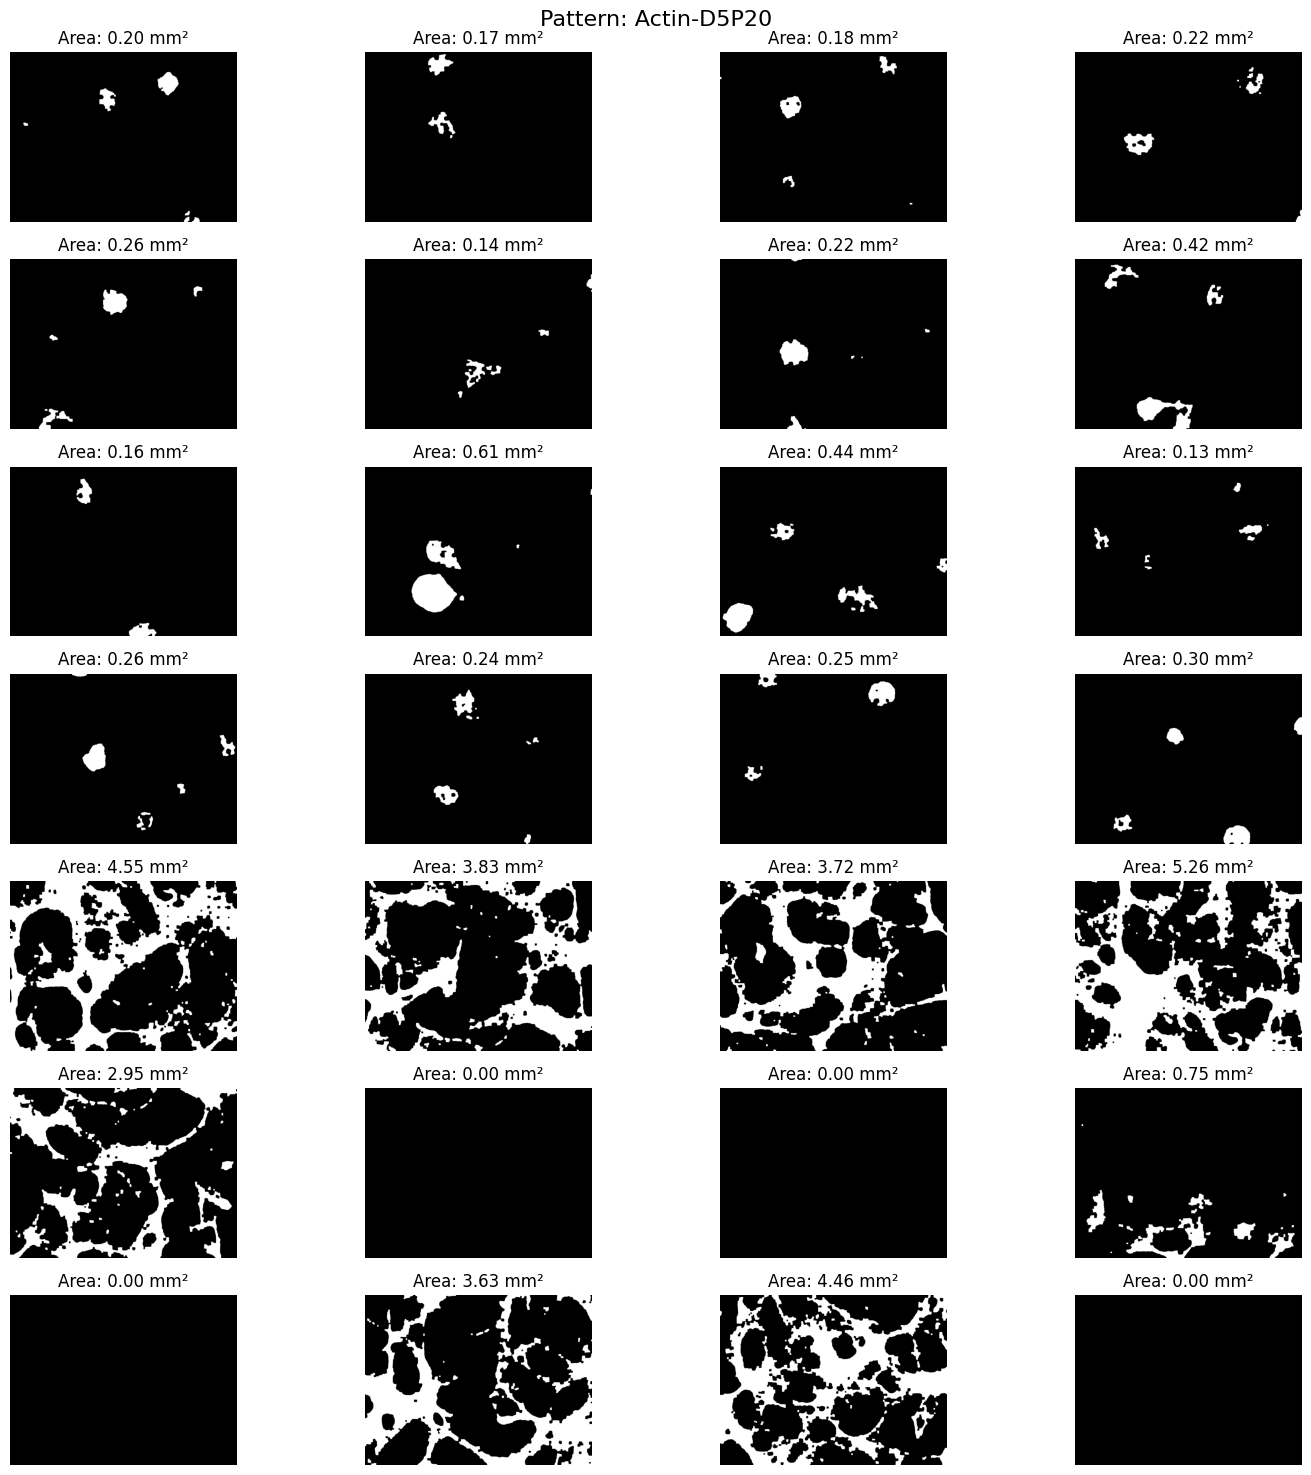

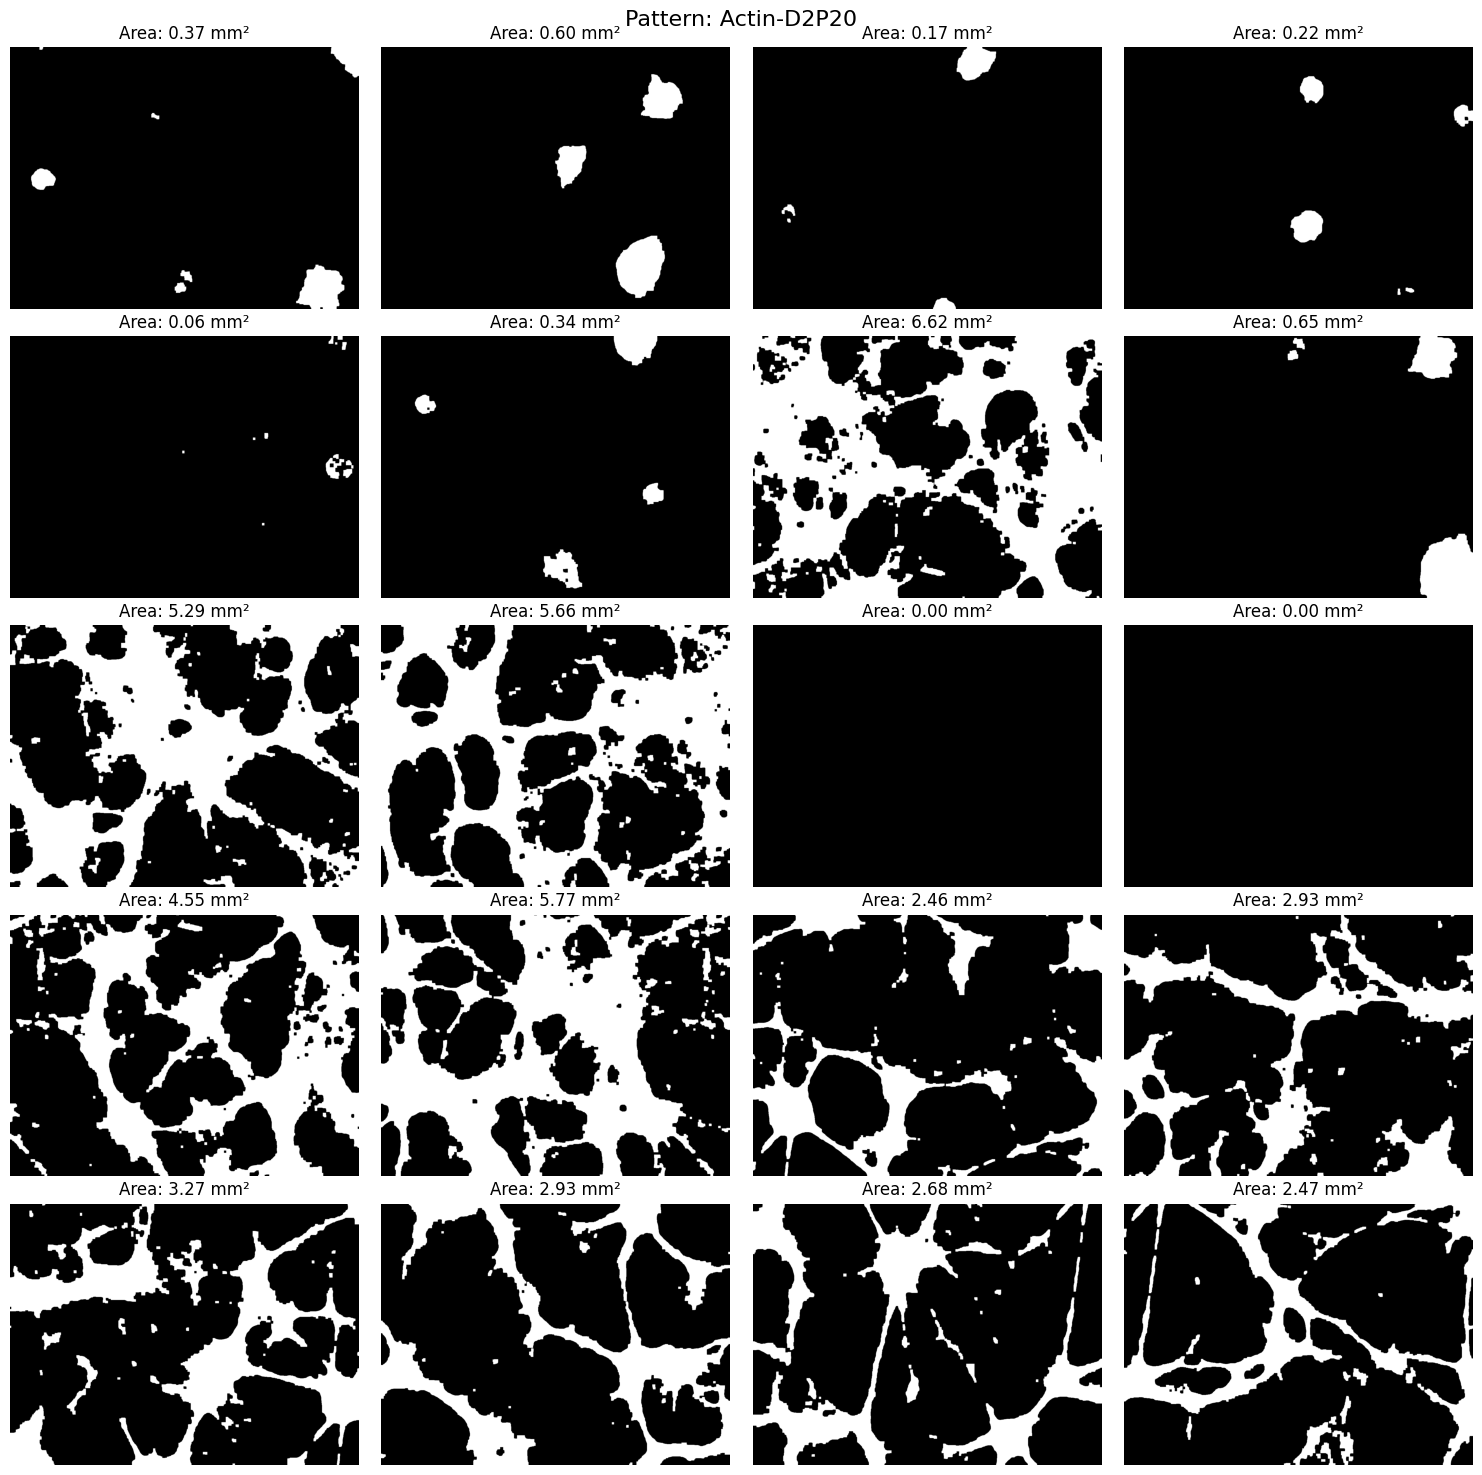

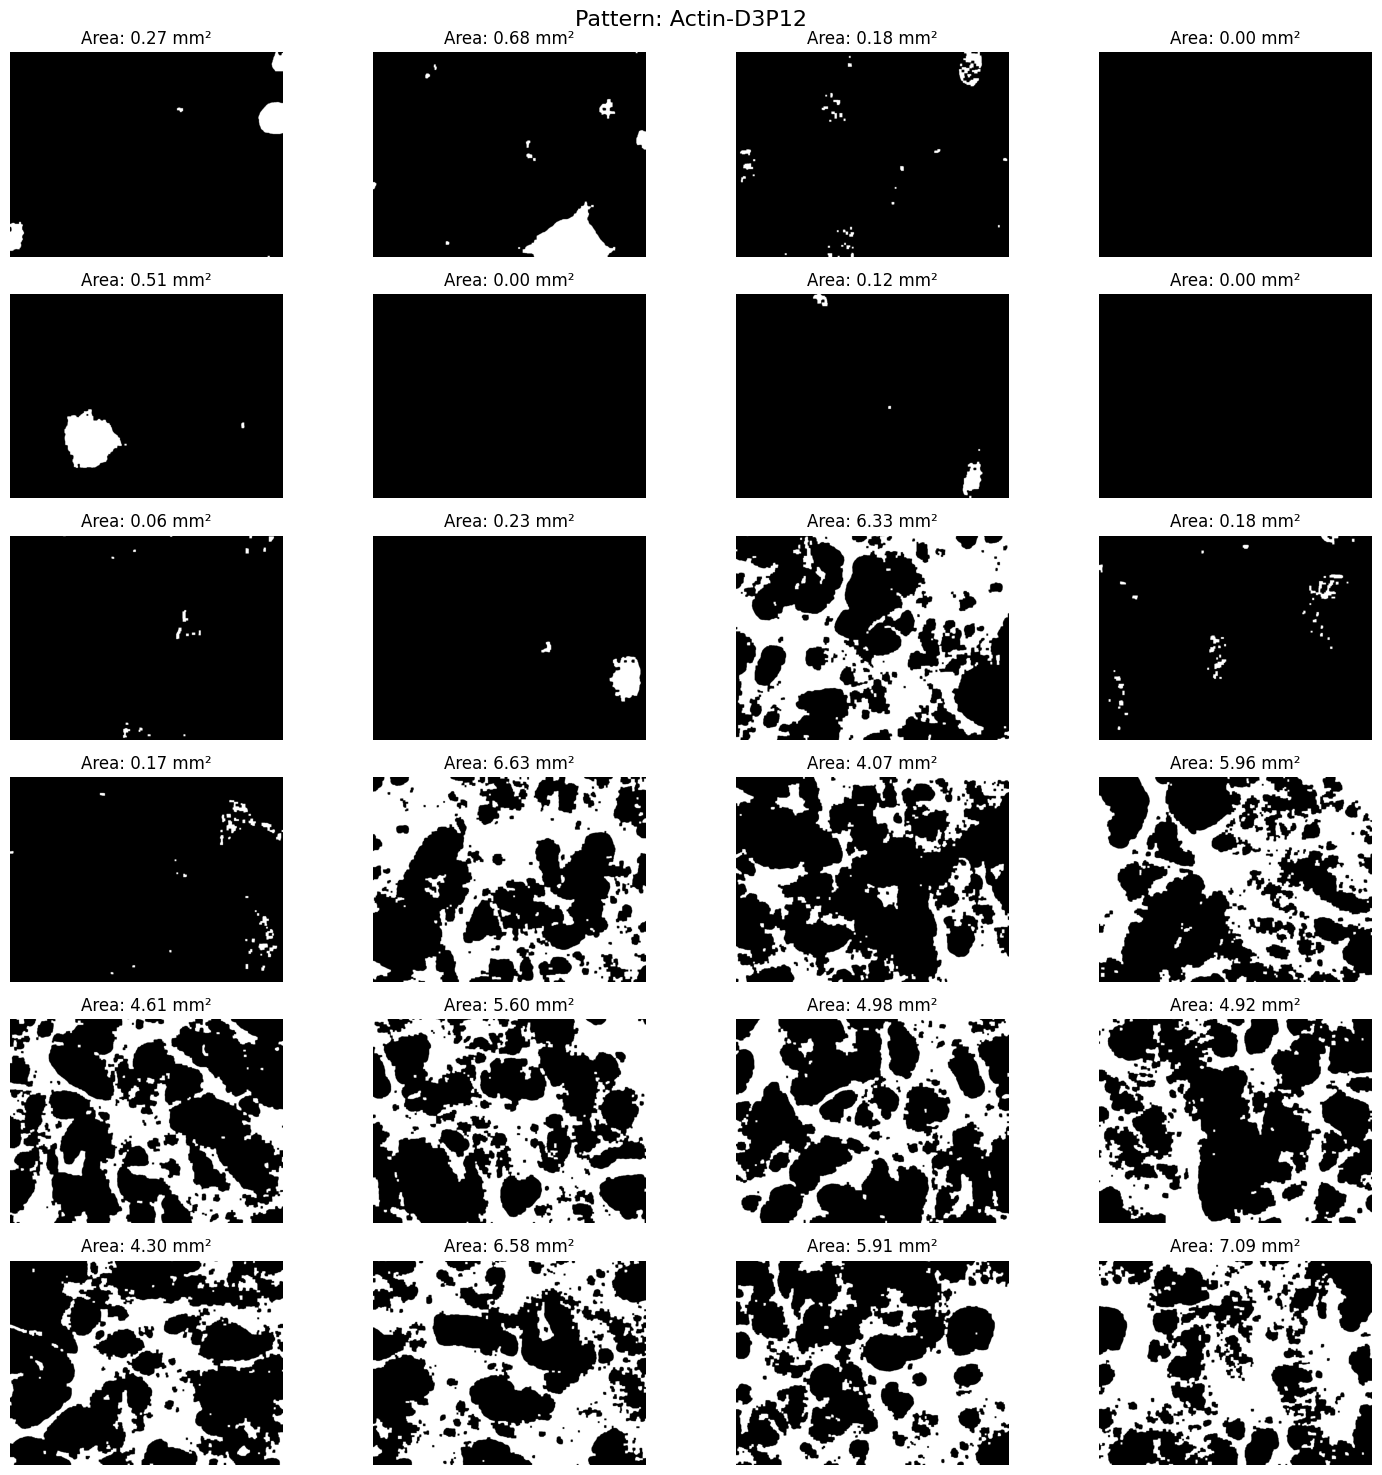

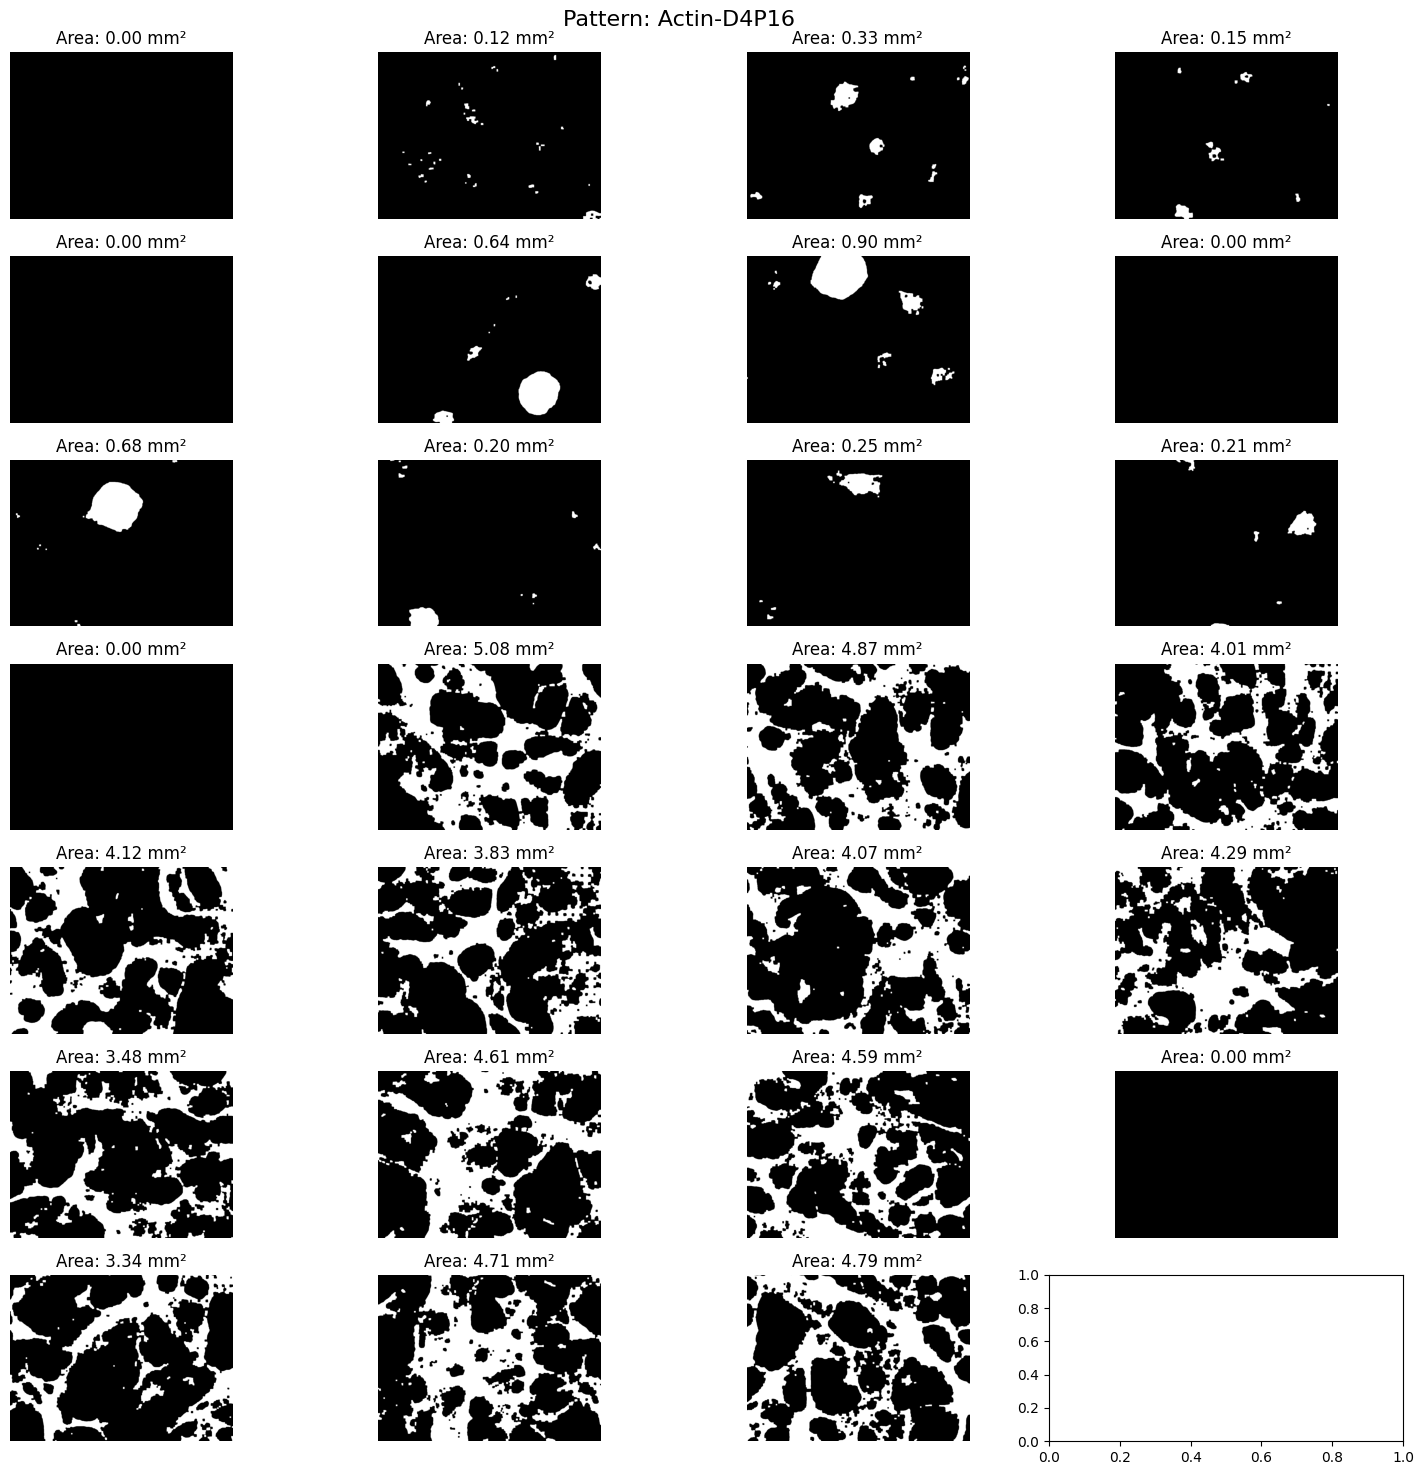

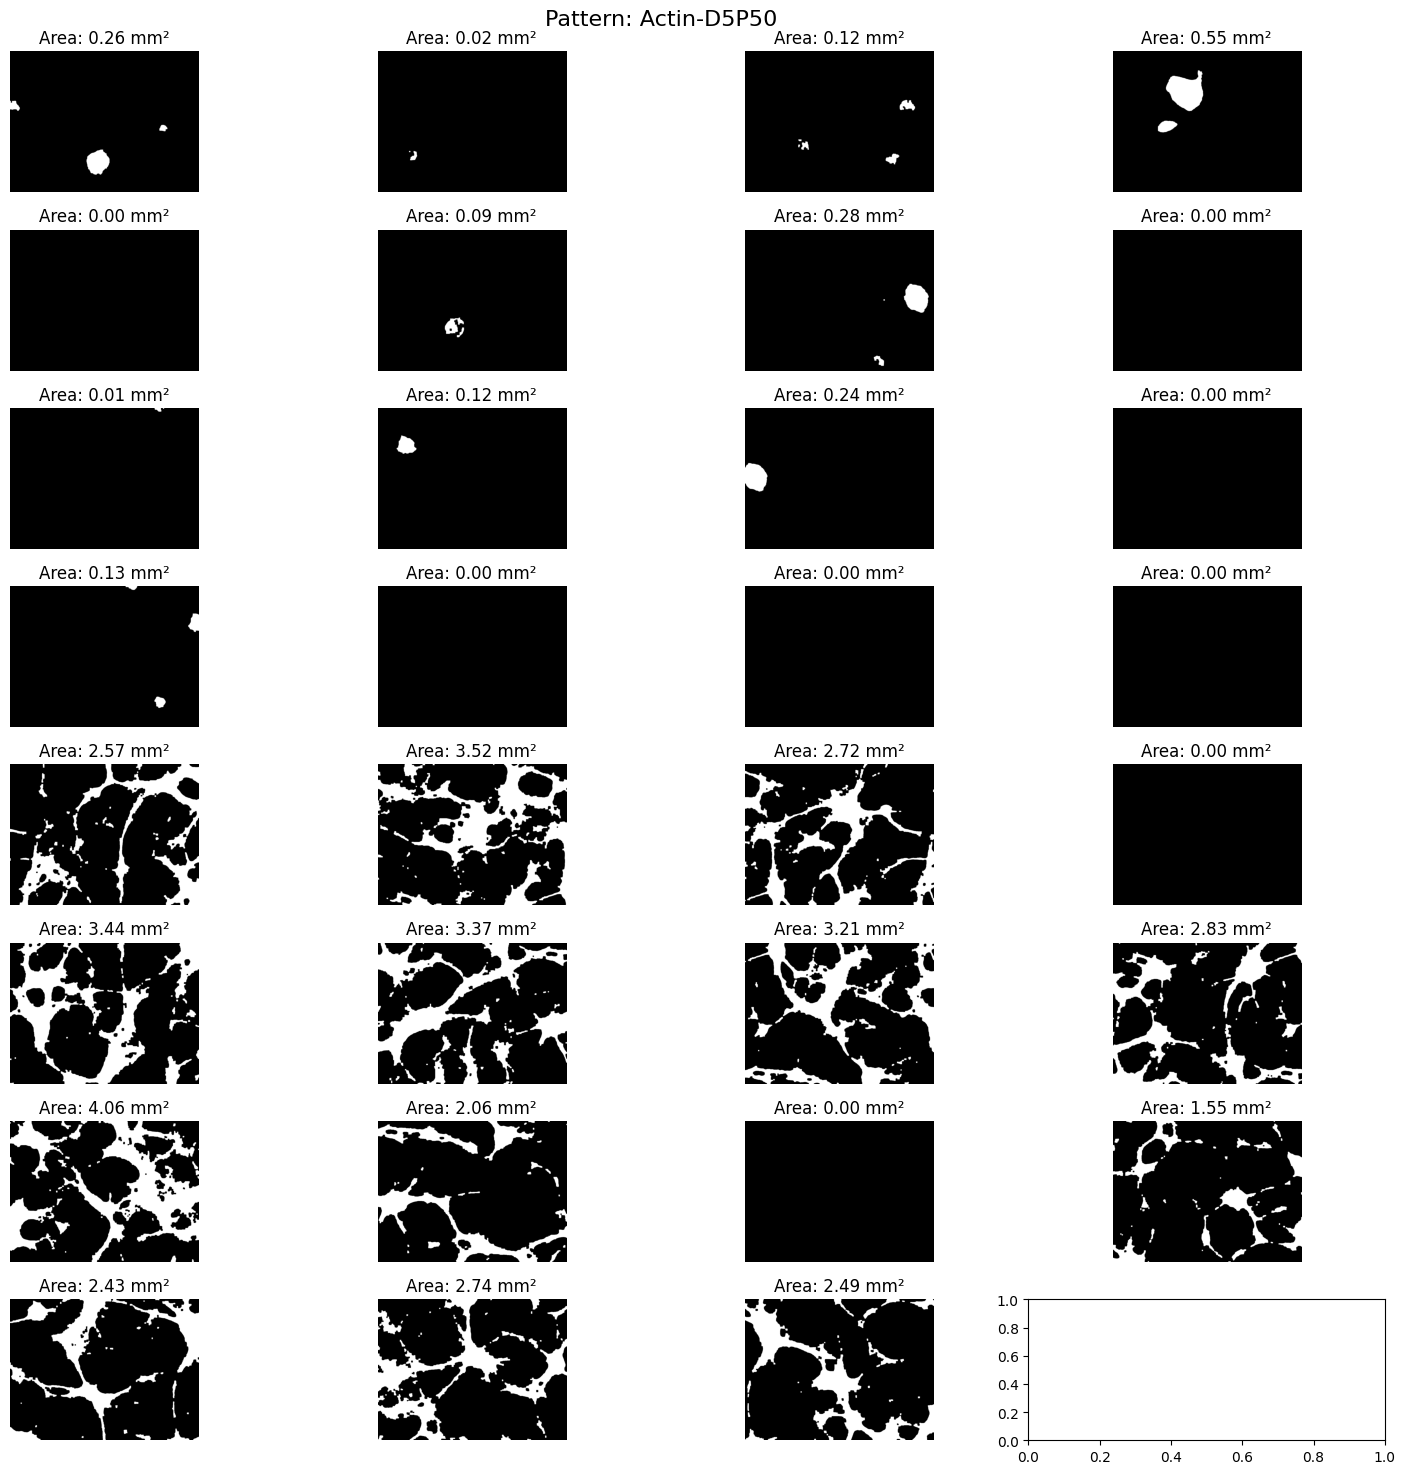

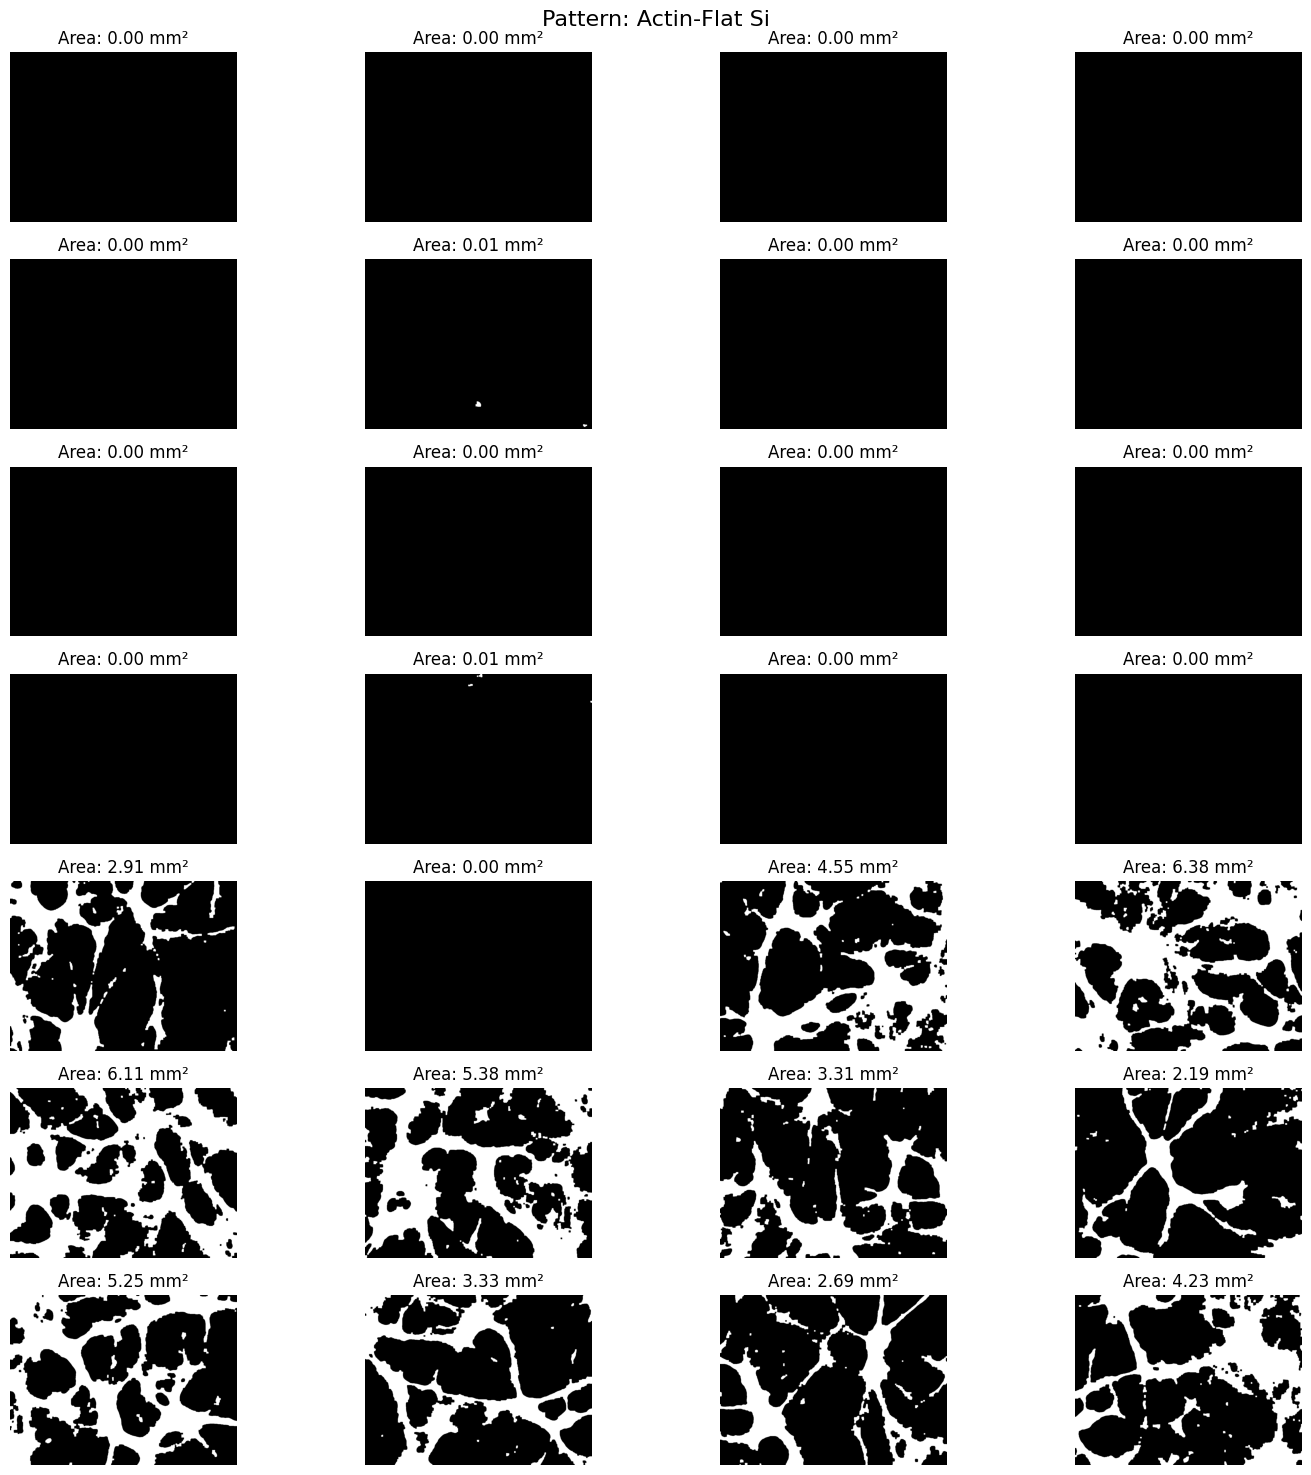

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro
import scipy.stats as stats

# Constants
SCALE_FACTOR = 1 / 3  # 3 pixels per micrometer

def apply_threshold(image, offset=5):
    # Apply Gaussian blurring and Otsu's thresholding
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    _, preliminary_threshold = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    final_threshold = int(preliminary_threshold[0][0] + offset)
    _, binary_image = cv2.threshold(image, final_threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def apply_morphological_operations(binary_image):
    # Apply morphological operations to clean up the binary image
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.erode(binary_image, kernel, iterations=4)
    binary_image = cv2.dilate(binary_image, kernel, iterations=2)
    # binary_image = cv2.erode(binary_image, kernel, iterations=1)
    return binary_image

def calculate_area(binary_image, scale_factor):
    # Calculate the total area of the coverage in square pixels
    white_pixel_count = np.sum(binary_image == 255)

    # Check if the image is completely black
    if white_pixel_count == 0:
        return 0  # If there are no white pixels, the area is 0

    # If there are white pixels, calculate the area
    total_area_mm2 = white_pixel_count / (scale_factor ** 2 * 10**6)
    return total_area_mm2

def additional_processing(image, scale_factor):
    # Calculate gradient magnitude using the Sobel operator
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply thresholding to detect bright regions
    threshold = 2  # Adjust as needed
    binary_image = cv2.threshold(blurred_image, threshold, 255, cv2.THRESH_BINARY)[1]

    # Combine binary image and gradient magnitude
    peak_mask = cv2.bitwise_and(binary_image, (gradient_magnitude > threshold).astype(np.uint8) * 255)

    # Apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    peak_mask = cv2.morphologyEx(peak_mask, cv2.MORPH_CLOSE, kernel)

    return peak_mask

def calculate_intensity_stats(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    non_zero_values = masked_image[masked_image != 0]

    if non_zero_values.size == 0:
        return 0, 0, 0  # Return default values if there are no non-zero values

    max_intensity = np.max(non_zero_values)
    min_intensity = np.min(non_zero_values)
    mean_intensity = np.mean(non_zero_values)
    return max_intensity, min_intensity, mean_intensity

def process_images_in_folder(folder_path, folder_title, scale_factor):
    # Initialize the subplot variables
    num_cols = 4  # Number of columns in the subplot grid
    num_rows = ((len(os.listdir(folder_path)) + num_cols - 1) // num_cols)  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    folder_data = []

    # Get the list of image files in the subfolder
    image_files = [filename for filename in os.listdir(folder_path) if filename.endswith(".tif")]

    # Iterate over the files in the subfolder
    for i, filename in enumerate(image_files):
        if filename.endswith(".tif"):
            # Load the image
            image_path = os.path.join(folder_path, filename)
            image_color = cv2.imread(image_path)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Apply thresholding and display the binary image for debugging
            binary_image = apply_threshold(image, offset=5)

            # Apply morphological operations and display the result for debugging
            binary_image = apply_morphological_operations(binary_image)

            # Calculate the total area using the binary image
            total_area_mm2 = calculate_area(binary_image, SCALE_FACTOR)
            # print(f"Calculated area for {filename}: {total_area_mm2:.2f} mm²")  # Debugging print statement

            # Initialize the data entry dictionary
            data_entry = {
                'filename': filename,
                'area_mm2': total_area_mm2,
                'max_intensity': 0,
                'min_intensity': 0,
                'mean_intensity': 0,
                'used_peak_mask': False
            }

            # If the area is non-zero, calculate intensity statistics
            if total_area_mm2 > 0:
                max_intensity, min_intensity, mean_intensity = calculate_intensity_stats(image, binary_image)
                data_entry.update({
                    'max_intensity': max_intensity,
                    'min_intensity': min_intensity,
                    'mean_intensity': mean_intensity,
                })

                # If the area is very small but not zero, consider additional processing
                if total_area_mm2 < 0.1:
                    peak_mask = additional_processing(image, SCALE_FACTOR)
                    # Apply morphological operations to refine peak detection
                    binary_image = apply_morphological_operations(peak_mask)
                    total_area_mm2 = calculate_area(binary_image, SCALE_FACTOR)  # Recalculate area
                    max_intensity, min_intensity, mean_intensity = calculate_intensity_stats(image, binary_image)

                    # Update the data entry with new values
                    data_entry.update({
                        'area_mm2': total_area_mm2,
                        'max_intensity': max_intensity,
                        'min_intensity': min_intensity,
                        'mean_intensity': mean_intensity,
                        'used_peak_mask': True
                    })

            # Append the data entry to folder_data
            folder_data.append(data_entry)

            # Display the image in the subplot (including images with area < 1 mm²)
            row = i // num_cols
            col = i % num_cols
            title = f"Area: {total_area_mm2:.2f} mm²"
            axes[row, col].imshow(binary_image, cmap='gray')
            axes[row, col].set_title(title)
            axes[row, col].axis('off')

    # Set the title for the subplots as the folder name
    plt.suptitle(folder_title, fontsize=16)

    # Adjust the layout and show the subplots for the current subfolder
    plt.tight_layout()
    plt.show()

    return folder_data

def main():
    parent_folder = '/content/drive/MyDrive/MAIA/3.Semester/Germany Master Thesis/Neuroimaging project/Cell_coverage/Actin'
    subfolders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]
    all_data = {}
    for subfolder in subfolders:
        folder_path = os.path.join(parent_folder, subfolder)
        folder_title = f"Pattern: {subfolder}"
        folder_data = process_images_in_folder(folder_path, folder_title, SCALE_FACTOR)
        all_data[subfolder] = folder_data

if __name__ == "__main__":
    main()
